# Project 1 Machine Learning
## Build predictive models to predict a classifiction, i.e., player's hand (righty or lefity) by using the ATP historic match data or if a palyer wins a match based on the historic match results.


### Used OLS and Lasso to exam the importance of the features and evaluate the relationship between the predictor variables and response variable

### Used the below models to learn the predictor variables and predict the response variable

   KNeighborsClassifier

   LogisticRegression

   Bagging - RandomForestClassifier

   Boosting - Gradient Boosting

### Used train_test_split, cross_val_score, GridSearchCV to tune and learn models

### Used learning_curve and other metric to compare the model performance


In [2421]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import seed
import seaborn as sns; sns.set(color_codes=True)
from os import listdir
import re
from scipy.stats import stats
from scipy import stats
from statsmodels.nonparametric.kernel_regression import KernelReg

import matplotlib as mpl
import statsmodels.formula.api as sm

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, Lasso, Ridge, BayesianRidge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, cross_validate
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report, accuracy_score, SCORERS
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor

from sklearn.dummy import DummyRegressor

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2272]:
df = pd.read_csv('data/RL_v.csv')
df2 = pd.read_csv('data/RL_h.csv')
df_all = pd.read_csv('data/all_v_00_19.csv')

Add a few calcualted columns

In [2273]:
df_all.loc[df_all.player_hand=='R', 'player_hand_flag'] = 1
df_all.loc[df_all.player_hand=='L', 'player_hand_flag'] = 0

In [2274]:
df_all['svpt_won_pct']= np.around((df_all.sv1stWon + df_all.sv2ndWon)/df_all.svpt,2)
df_all['svpt_std_var']=df_all.svpt - df_all.SvGms*4
df_all['bpSaved_pct'] = np.around(df_all.bpSaved/df_all.bpFaced,2)
df_all.bpSaved_pct.fillna(0, inplace=True)

In [2275]:
df.loc[df.player_hand=='R', 'player_hand_flag'] = 1
df.loc[df.player_hand=='L', 'player_hand_flag'] = 0

In [2276]:
df.loc[(df.surface=='Hard'), 'surface_id'] = 1
df.loc[(df.surface=='Clay'), 'surface_id'] = 2
df.loc[(df.surface=='Grass'), 'surface_id'] = 3
df.loc[(df.surface=='Carpet'), 'surface_id'] = 4

In [2277]:
df.loc[(df.tourney_level=='A'), 'tourney_level_id'] = 1
df.loc[(df.tourney_level=='G'), 'tourney_level_id'] = 2
df.loc[(df.tourney_level=='M'), 'tourney_level_id'] = 3

In [2278]:
df.loc[(df.player_rank >=1) & (df.player_rank<=30), 'player_rank_group'] = 1
df.loc[(df.player_rank >=11) & (df.player_rank<=60), 'player_rank_group'] = 2
df.loc[(df.player_rank >=61) & (df.player_rank<=100), 'player_rank_group'] = 3
df.loc[(df.player_rank >=101), 'player_rank_group'] = 4

add svpt_won_pct and bpSaved_pct to make serving data at the same scale

In [2279]:
df['svpt_won_pct']= np.around((df.sv1stWon + df.sv2ndWon)/df.svpt,2)

In [2280]:
# calculate how many additaionl serves to win the serving game.  
df['svpt_std_var']=df.svpt - df.SvGms*4

In [2281]:
df['bpSaved_pct'] = np.around(df.bpSaved/df.bpFaced,2)
df.bpSaved_pct.fillna(0, inplace=True)

In [2282]:
df.columns

Index(['Unnamed: 0', 'tourney_id', 'tourney_name', 'surface', 'tourney_level',
       'tourney_date', 'match_num', 'player_id', 'player_name', 'player_hand',
       'player_ht', 'player_ioc', 'player_age', 'score', 'best_of', 'round',
       'minutes', 'ace', 'df', 'svpt', 'sv1stIn', 'sv1stWon', 'sv2ndWon',
       'SvGms', 'bpSaved', 'bpFaced', 'player_rank', 'player_rank_points',
       'ace_pct', 'df_pct', 'sv1stIn_pct', 'sv2ndIn_pct', 'sv1stWon_pct',
       'sv2ndWon_pct', 'GmsWon', 'GmsLoss', 'year', 'opponent_id',
       'opponent_name', 'won_flag', 'player_age_bucket', 'player_hand_flag',
       'surface_id', 'tourney_level_id', 'player_rank_group', 'svpt_won_pct',
       'svpt_std_var', 'bpSaved_pct'],
      dtype='object')

There are 14 rows have data issues on svpt_won_pct.  Since volume is small so just ignore it.

In [2283]:
df[df.svpt_won_pct>=1][['score','sv1stIn','sv1stIn_pct','sv1stWon','svpt','svpt_won_pct', 'svpt_std_var', 'SvGms','ace_pct','df_pct','GmsWon','GmsLoss','won_flag','sv2ndWon','ace','df','bpFaced','bpSaved', 'player_age', 'player_rank']].head()

,score,sv1stIn,sv1stIn_pct,sv1stWon,svpt,svpt_won_pct,svpt_std_var,SvGms,ace_pct,df_pct,GmsWon,GmsLoss,won_flag,sv2ndWon,ace,df,bpFaced,bpSaved,player_age,player_rank
2460,6-2 3-6 6-4,32.0,0.70,47.0,46.0,1.78,-6.0,13.0,0.07,0.15,15.0,12.0,1,35.0,3.0,7.0,9.0,5.0,29.51,127.0
2461,6-2 3-6 6-3,27.0,0.52,38.0,52.0,1.38,0.0,13.0,0.12,0.08,15.0,11.0,1,34.0,6.0,4.0,3.0,1.0,22.06,35.0
2462,3-6 7-5 6-2,41.0,0.73,56.0,56.0,1.46,0.0,14.0,0.14,0.04,16.0,13.0,1,26.0,8.0,2.0,3.0,1.0,24.84,37.0
2463,7-6(2) 6-4,36.0,0.73,42.0,49.0,1.43,5.0,11.0,0.06,0.10,12.0,10.0,1,28.0,3.0,5.0,1.0,0.0,24.01,21.0
2464,6-4 3-6 6-3,39.0,0.70,47.0,56.0,1.41,0.0,14.0,0.30,0.14,15.0,13.0,1,32.0,17.0,8.0,3.0,2.0,22.06,35.0


In [2284]:
df[df.svpt_won_pct>=1].player_id.count()

14

In [2285]:
df[(df.tourney_id=='2003-1536') & (df.player_id==103819)][['score','sv1stIn','sv1stIn_pct','sv1stWon','svpt','svpt_won_pct', 'svpt_std_var', 'SvGms','ace_pct','df_pct','GmsWon','GmsLoss','won_flag','sv2ndWon','ace','df','bpFaced','bpSaved', 'player_age', 'player_rank']]

,score,sv1stIn,sv1stIn_pct,sv1stWon,svpt,svpt_won_pct,svpt_std_var,SvGms,ace_pct,df_pct,GmsWon,GmsLoss,won_flag,sv2ndWon,ace,df,bpFaced,bpSaved,player_age,player_rank
2466,4-6 7-6(3) 6-4,42.0,0.63,52.0,67.0,1.46,3.0,16.0,0.15,0.06,16.0,16.0,1,46.0,10.0,4.0,8.0,7.0,22.18,3.0


In [2286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20132 entries, 0 to 20131
Data columns (total 48 columns):
Unnamed: 0            20132 non-null int64
tourney_id            20132 non-null object
tourney_name          20132 non-null object
surface               20132 non-null object
tourney_level         20132 non-null object
tourney_date          20132 non-null int64
match_num             20132 non-null int64
player_id             20132 non-null int64
player_name           20132 non-null object
player_hand           20132 non-null object
player_ht             20132 non-null float64
player_ioc            20132 non-null object
player_age            20132 non-null float64
score                 20132 non-null object
best_of               20132 non-null int64
round                 20132 non-null object
minutes               20132 non-null float64
ace                   20132 non-null float64
df                    20132 non-null float64
svpt                  20132 non-null float64
sv1stIn   

Functions

In [2287]:
def plot_ol_coef(axis_names, f):
    # use Ordinary Least Squares to exam the relationship between the predictor variables (the X) and the response (the y)
    reg = sm.ols(f, data=df).fit()
    reg_results = reg.summary()
    print(reg_results)
    # print
    print('params:')
    print(reg.params)
    print()
    print()
    print('conf_int:')
    print(reg.conf_int())
    print()
    print()
    print('err_series:')
    err_series = reg.params - reg.conf_int()[0]
    print(err_series)
    print()
    print()
    print('coef_df:')
    coef_df = pd.DataFrame({'coef': reg.params.values[1:],
                        'err': err_series.values[1:],
                        'varname': err_series.index.values[1:]
                       })
    print(coef_df)
    print()
    print()
    
    # plot
    fig, ax = plt.subplots(figsize=(12 ,5))
    # plot error bar
    coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, #color='none', 
             yerr='err', 
             legend=False)
    ax.set_ylabel('coef')
    ax.set_xlabel('columns')
    # scatter plot 
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
    ax.xaxis.set_ticks_position('none')
    _ = ax.set_xticklabels(axis_columns, 
                       rotation=45, fontsize=16)
    
    return reg.params, reg.conf_int(), err_series, coef_df

In [2288]:
#sns.heatmap(df.corr(), square=True, cmap='RdYlGn')

In [2289]:
def display_plot(cv_scores, cv_scores_std):
    alpha_space = np.logspace(-4, 0, 50)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

In [2290]:
#from sklearn.linear_model import Lasso
#from sklearn.model_selection import cross_val_score

# Setup the array of alphas and lists to store scores
def plot_lasso_alpha(X,y):
    alpha_space = np.logspace(-4, 0, 50)
    lasso_scores = []
    lasso_scores_std = []
    
    # Create a ridge regressor: ridge
    lasso = Lasso(normalize=True)
    
    # Compute scores over range of alphas
    for alpha in alpha_space:
        # Specify the alpha value to use: ridge.alpha
        lasso.alpha = alpha
        
        # Perform 5-fold CV: lasso_cv_scores
        lasso_cv_scores = cross_val_score(lasso,X,y,cv=5)
        
        # Append the mean of ridge_cv_scores to ridge_scores
        lasso_scores.append(np.mean(lasso_cv_scores))
        
        # Append the std of ridge_cv_scores to ridge_scores_std
        lasso_scores_std.append(np.std(lasso_cv_scores))
        
    # Display the plot
    display_plot(lasso_scores, lasso_scores_std)
    return lasso_scores, lasso_scores_std
  

In [2291]:
def plot_lasso_features(names, X, y, alpha=0.01):
    
    plt.figure(figsize=(8,8))
    
    lasso = Lasso(alpha=alpha)
    lasso_coef = lasso.fit(X, y).coef_ 
    _ = plt.plot(range(len(names)), lasso_coef) 
    _ = plt.xticks(range(len(names)), names, rotation=60) 
    _ = plt.ylabel('Coefficients') 
    plt.show() 

In [2292]:
def make_CV_models(X, y):
    '''performs grid searches to find all the best models for dataset X, y'''

    model_dict = {
            #'KRR'    : GridSearchCV(X, y, KernelRidge(), param_grid={"alpha": np.logspace(-10, 2, 300), "gamma": np.logspace(-10, -1, 100), "kernel" : ['rbf']}),
          #  'SVR'   : GridSearchCV(X, y, SVR(), param_grid={"C": np.logspace(-1, 4, 20), "epsilon": np.logspace(-2, 2, 20)}),
           # 'Ridge' : GridSearchCV(X, y, Ridge(), param_grid={"alpha": np.logspace(-6, 6, 150)} ),
           # 'Lasso' : GridSearchCV(X, y, Lasso(max_iter = 20000), param_grid={"alpha": np.logspace(-2, 6, 100)} ),
          #  'BR'    : GridSearchCV(X, y, BayesianRidge(), param_grid={"alpha_1": np.logspace(-13,-5,10),"alpha_2": np.logspace(-9,-3,10), "lambda_1": np.logspace(-10,-5,10),"lambda_2": np.logspace(-11,-4,10)}) ,
          #  'GBoost': GridSearchCV(X, y, GradientBoostingRegressor(), param_grid={"n_estimators": np.linspace(5, 350, 100).astype('int')} ),
          #  'RF'    : GridSearchCV(X, y, RandomForestRegressor(), param_grid={"n_estimators": np.linspace(5, 100, 50).astype('int')}, ),
            'kNN'   : GridSearchCV(X, y, KNeighborsRegressor(), param_grid={"n_neighbors": list(range(1, 31))} )#,
          #  'mean'  : DummyRegressor(strategy='mean'),
            }

    return model_dict

In [2293]:
def knn_k_grid_search(X, y, n_CV=5):
    #from sklearn.grid_search import GridSearchCV 
    
    '''
    knn = KNeighborsClassifier()
     
    k_range = np.arange(1,31)
    
    params = {"n_neighbors": k_range,  
          "metric": ["euclidean", "cityblock"]} 
    grid = GridSearchCV(estimator=knn, param_grid=params, cv=n_CV, scoring='accuracy', n_jobs=-1) #scoring='roc_auc') 
    grid.fit(X, y) 
    print(grid.best_score_) 
    print(grid.best_estimator_.n_neighbors)
    '''
    k_range = list(range(1, 31))
    print(k_range)
    
    param_grid = dict(n_neighbors=k_range)
    print(param_grid)
    
    knn = KNeighborsClassifier()
    
    # instantiate the grid
    grid = GridSearchCV(knn, param_grid, cv=n_CV, scoring='roc_auc', n_jobs=-1) #scoring='roc_auc' scoring='accuracy'
    # fit the grid with data
    grid.fit(X, y)

    grid_mean_scores = grid.cv_results_['mean_test_score']
    print('')
    print('Mean Test Score')
    print(grid_mean_scores.mean())
    
    knn_neighbors = grid.best_params_
    print(knn_neighbors)
    print(grid.best_score_)
    
    # plot the results
    # this is identical to the one we generated above
    plt.plot(k_range, grid_mean_scores, marker='o')
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    
    return grid, grid.best_estimator_.n_neighbors

In [2294]:
def knn_cross_val_scores(X, y, k, cv=5):
    # K-fold cross-validation

    knn = KNeighborsClassifier(n_neighbors=k)
    
    cv_scores = cross_val_score(knn, X, y, cv=n_CV, scoring='roc_auc', n_jobs=-1)
    print('CV Scores:')
    print(cv_scores)
    print('Average CV Score:')
    print(cv_scores.mean())
    print()
    print()
    
    return cv_scores

In [2416]:
def get_cross_val_scores_oob (model, X, y, n_CV=4):
    # K-fold cross-validation
    
    cv_scores = cross_val_score(model, X, y, 
                                cv=n_CV, 
                                #cv=4,
                               # scoring='accuracy',
                                scoring='roc_auc',
                                n_jobs=-1)
    print('CV Scores:')
    print(cv_scores)
    print('Average CV Score:')
    print(cv_scores.mean())
    print()
    print()
    
    return cv_scores

In [2418]:
def get_cross_val_scores(model, X, y, n_CV=4):
    # K-fold cross-validation
    
    scoring = {
           'roc_auc': 'roc_auc',
           'accuracy': 'accuracy',
           'f1': 'f1',
           'precision': 'precision',
           'recall': 'recall'
           }
    
    cv_scores =cross_validate(model, X, y, 
                                cv=n_CV, 
                                scoring=scoring,
                                n_jobs=-1)

    #print('Cross Validation Average Scores:')
    print('roc_uac:', cv_scores['test_roc_auc'].mean())
    print('accuracy:', cv_scores['test_accuracy'].mean())
    print('f1:', cv_scores['test_f1'].mean())
    print('precision:', cv_scores['test_precision'].mean())
    print('recall:', cv_scores['test_recall'].mean())
    print()
    print()
    
    return cv_scores

In [2296]:
def run_train_testing_split(model, X_train, X_test, y_train, y_test):
    # train and test split
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)  
    
    #knn = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print('classification report:')
    print(classification_report(y_test, y_pred))
    print('confusion matrix:')
    print(confusion_matrix(y_test, y_pred))
    print('mean squared error:')
    print(mean_squared_error(y_test, y_pred))
    print('r2 scores:')
    print (r2_score(y_test, y_pred))
    
    # ROC Curve
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    auc_score = roc_auc_score(y_test, y_pred_prob)
    print('ROC AUC Score: ')
    print(auc_score)
    #print('ROC AUC Score: ' + str(auc_score))    
    print()
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) # False Positive, True Positive, Threshold

    plt.figure(figsize=(12,12))
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

In [2297]:
def knn_cross_val_k_search(X,y,cv=5):
    k_range = range(1, 31)
    k_scores = []
    
    #loop through reasonable values of k
    for k in k_range: 
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=cv, scoring='roc_auc') 
        k_scores.append(scores.mean())
    print(k_scores)
    
    plt.plot(k_range, k_scores, marker='o')
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()
    
    return k_range, k_scores

In [2298]:
def knn_cross_val_k_search(X,y,cv=5):
    # parameter tuning using cross_val_score
    # Goal: To select the best value of k for KNN model to predict
    
    k_range = range(1, 31)
    
    # list of scores from k_range
    k_scores = []
    
    #loop through reasonable values of k
    for k in k_range: 
        # run KNeighborsClassifier with k neighbours
        knn = KNeighborsClassifier(n_neighbors=k)
        # obtain cross_val_score for KNeighborsClassifier with k neighbours
        scores = cross_val_score(knn, X, y, cv=cv, scoring='roc_auc') 
        # append mean of scores for k neighbors to k_scores list
        k_scores.append(scores.mean())
    print(k_scores)
    
    # plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
    plt.plot(k_range, k_scores, marker='o')
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()
    
    return k_range, k_scores

In [2525]:
def plot_learning_curve(model, X, y):
    # visualize the effect of the number of observations on the performance metric
    # Create CV training and test scores for various training set sizes
    train_sizes, train_scores, test_scores = learning_curve(model,#KNeighborsClassifier(), 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        #scoring='accuracy',
                                                        scoring='roc_auc',
                                                        shuffle=True,
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        #train_sizes=np.linspace(0.01, 1.0, 50)
                                                        train_sizes=np.linspace(0.01, 1.0, 30)
                                                           )
    
    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    
    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Draw lines
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")
    
    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.5)#"#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="b", alpha=0.5)#"#DDDDDD")

    # Create plot
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("ROC AUC Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

In [2300]:
n_CV = 10
p_test_size = 0.2
p_random_state= 42

# KNN

## Machine learning for Data Set 1 of selected predicotr variables (Xs) and response (won_flag) 

In [2540]:
model_columns=['sv1stIn', 'sv1stWon','svpt','sv2ndWon','ace','df','bpFaced', 'bpSaved', 'svpt_std_var']

names= df[model_columns].columns
X = df[model_columns].values
y=df['won_flag'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = p_test_size , random_state=p_random_state)  

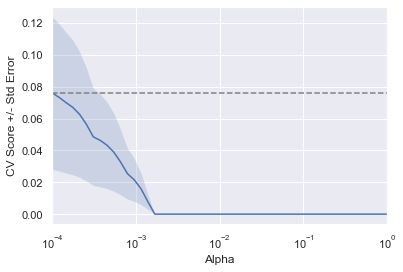

([0.07597072018929614,
  0.07324605797823291,
  0.07001225925692642,
  0.06697739016869615,
  0.06258544077563907,
  0.056264648887037416,
  0.04848116624859582,
  0.04632226625998748,
  0.04325584850798627,
  0.03888455359449021,
  0.03263290477963223,
  0.02539295374864674,
  0.02145100741875485,
  0.01580285802581729,
  0.007689051693476734,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -

In [2302]:
plot_lasso_alpha(X,y)

### Apply the selected alpha to Lasso model to exam the significant features 

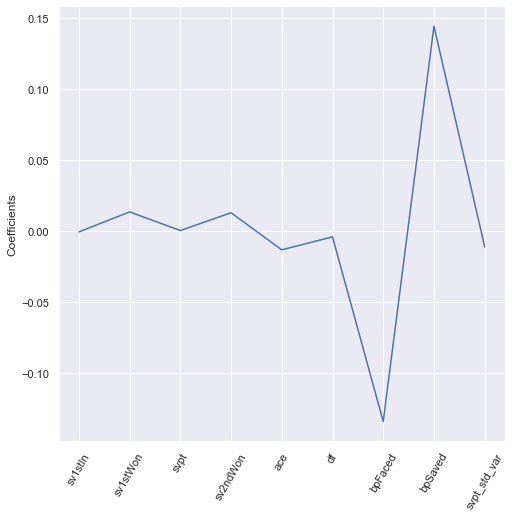

In [2303]:
plot_lasso_features(names, X, y, 0.001)

### Choose the best n_neighbors 

In [2456]:
# use cross val search best k from the list of k
# alternative way to ge tbest k
#k_range, k_scores = knn_cross_val_k_search(X_train, y_train, n_CV)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}

Mean Test Score
0.8444534688782358
{'n_neighbors': 30}
0.8633605000852458


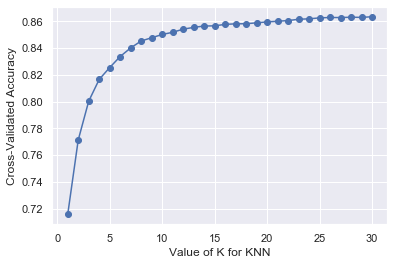

In [2541]:
# use grid serach to get the best k
g, k = knn_k_grid_search(X_train, y_train, n_CV)

Training cross validation scores:
roc_uac: 0.863359561149843
accuracy: 0.7739195234901347
f1: 0.7754791195916587
precision: 0.7689111004183765
recall: 0.7823826075103932


Testing cross validation scores:
roc_uac: 0.8386588072808867
accuracy: 0.7432343502038476
f1: 0.7419477967534457
precision: 0.7514455027986457
recall: 0.7328794514591002


classification report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1998
           1       0.77      0.77      0.77      2029

    accuracy                           0.77      4027
   macro avg       0.77      0.77      0.77      4027
weighted avg       0.77      0.77      0.77      4027

confusion matrix:
[[1543  455]
 [ 466 1563]]
mean squared error:
0.22870623292773776
r2 scores:
0.08512085274036973
ROC AUC Score: 
0.8649106227962808



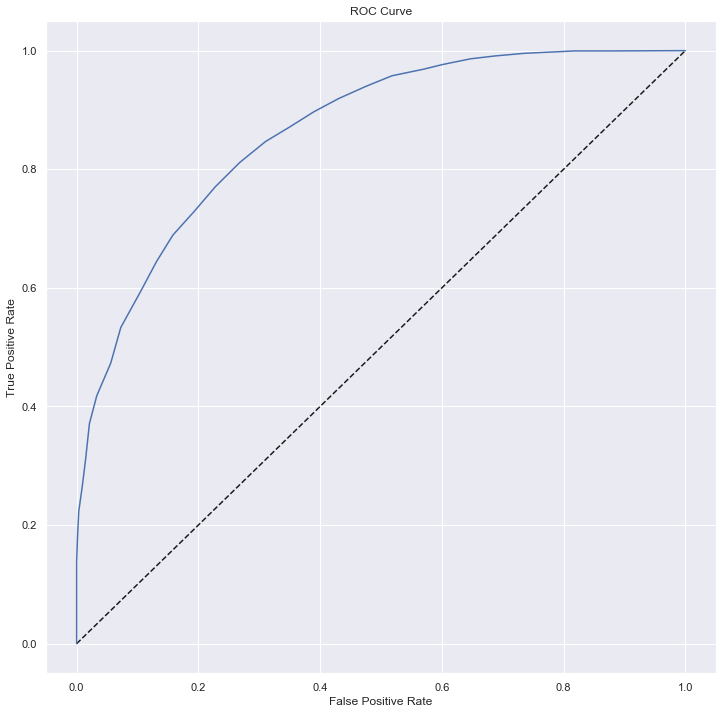

In [2426]:
knn = KNeighborsClassifier(n_neighbors=k)
print('Training cross validation scores:')
get_cross_val_scores(knn, X_train, y_train, n_CV=10);
print('Testing cross validation scores:')
get_cross_val_scores(knn, X_test, y_test, n_CV=4);
run_train_testing_split(knn, X_train, X_test, y_train, y_test)

### Exam learninig performance¶ 

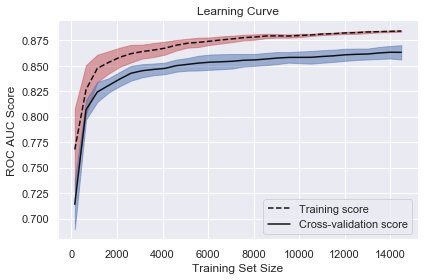

In [2542]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=k), X_train, y_train)

When size increases, training score increases and variance decreases.
When size increases, testig score increase.  But the variance doesn't decrease.

## Machine learning for Data Set 2 of selected predicotr variables (Xs) and response (won_flag) 

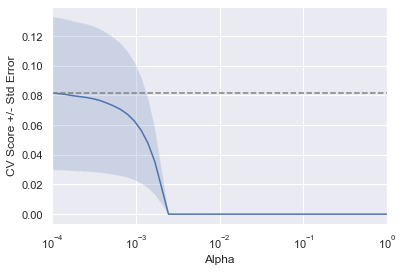

([0.08155531912299578,
  0.08114158418633104,
  0.0805742558977433,
  0.0797902700485535,
  0.07919137528478712,
  0.0785651069215781,
  0.07769774718282252,
  0.07648837861680773,
  0.07479209457655338,
  0.07282521143532047,
  0.07048205410151584,
  0.06725445330557615,
  0.06277702082283405,
  0.05652552896599905,
  0.04774605911282996,
  0.035352155310960656,
  0.01777545202946058,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.71153807

In [2427]:
# use percentage to re-scale the date
# run Lasso to find out the best alpha
model_columns= ['sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct', 'bpSaved_pct']
names= df[model_columns].columns
X = df[model_columns].values
y=df['won_flag'].values
plot_lasso_alpha(X,y)

### Apply the selected alpha to Lasso model to exam the significant features 

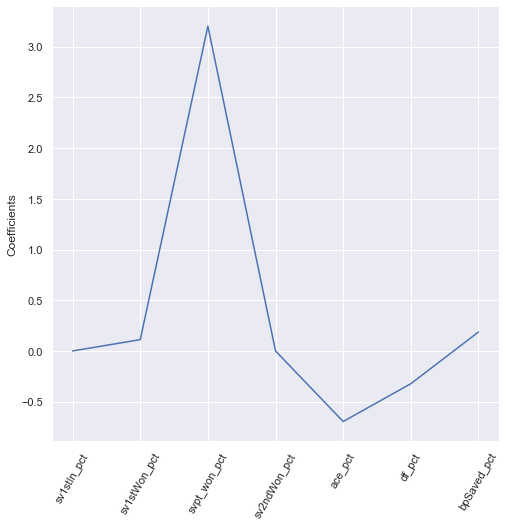

In [2428]:
plot_lasso_features(names, X, y, 0.0001)

In [2543]:
# split data into train and testing set
model_columns=['svpt_won_pct','ace_pct','df_pct','bpSaved_pct']
names= df[model_columns].columns
X = df[model_columns].values
y=df['won_flag'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = p_test_size , random_state=p_random_state)  

### Choose the best n_neighbors 

In [2517]:
# use cross val search best k from the list of k
# alternative way to ge tbest k
#k_range, k_scores = knn_cross_val_k_search(X_train, y_train, n_CV)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}

Mean Test Score
0.8603494004145064
{'n_neighbors': 30}
0.8801811354260738


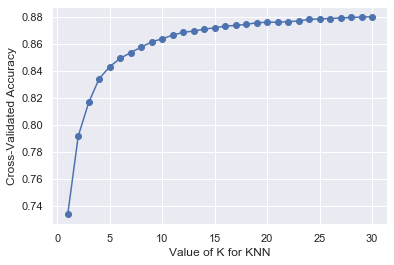

In [2544]:
# use grid serach to get the best k
g, k = knn_k_grid_search(X_train, y_train, n_CV)

Training cross validation scores:
roc_uac: 0.8801804688538744
accuracy: 0.7922988749622153
f1: 0.7913953971057881
precision: 0.7932540146016283
recall: 0.78984544896935


Testing cross validation scores:
roc_uac: 0.876617197793839
accuracy: 0.7891739793697894
f1: 0.791684591364431
precision: 0.7881684844643593
recall: 0.7954745764028017


classification report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1998
           1       0.80      0.79      0.79      2029

    accuracy                           0.79      4027
   macro avg       0.79      0.79      0.79      4027
weighted avg       0.79      0.79      0.79      4027

confusion matrix:
[[1591  407]
 [ 422 1607]]
mean squared error:
0.20586044201638937
r2 scores:
0.17650943205403524
ROC AUC Score: 
0.8811056004254623



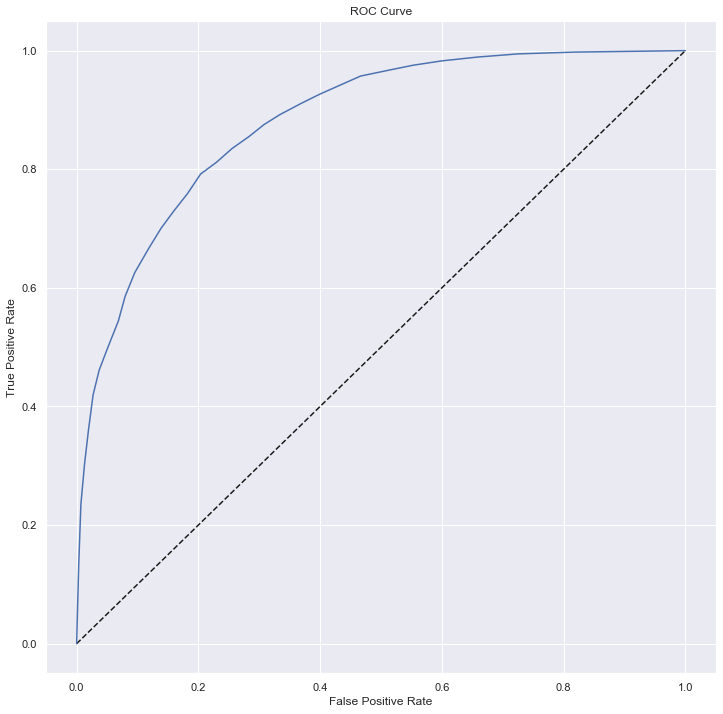

In [2431]:
knn = KNeighborsClassifier(n_neighbors=k)
print('Training cross validation scores:')
get_cross_val_scores(knn, X_train, y_train, n_CV=10);
print('Testing cross validation scores:')
get_cross_val_scores(knn, X_test, y_test, n_CV=4);
run_train_testing_split(knn, X_train, X_test, y_train, y_test)

### Exam learninig performance¶ 

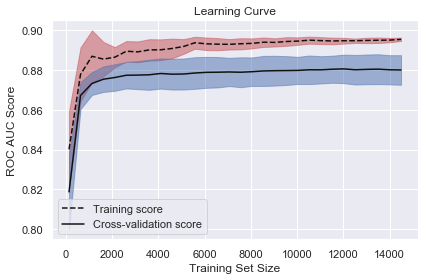

In [2545]:
#plot_learning_curve(KNeighborsClassifier(), X_train, y_train)
plot_learning_curve(KNeighborsClassifier(n_neighbors=k), X_train, y_train)

## Machine learning for Data Set 3 of selected predicotr variables (Xs) and response (won_flag) 

Further reduce features to most significant features, svpt_won_pct and bpSaved_pct

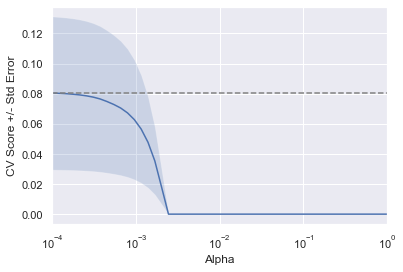

([0.0804108728452528,
  0.08022710214638303,
  0.07998050791138611,
  0.07964677162047004,
  0.07919137676955072,
  0.07856514109426253,
  0.07769774840675103,
  0.07648840713148894,
  0.07479210691084226,
  0.07282521143532047,
  0.07048205410151584,
  0.06725445330557615,
  0.06277702082283405,
  0.05652552896599905,
  0.04774605911282996,
  0.035352155310960656,
  0.01777545202946058,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538

In [2546]:
# use percentage to re-scale the date
# run Lasso to find out the best alpha
model_columns=['svpt_won_pct', 'bpSaved_pct']
names= df[model_columns].columns
X = df[model_columns].values
y=df['won_flag'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = p_test_size , random_state=p_random_state)  

plot_lasso_alpha(X,y)

### Choose the best n_neighbors

In [2518]:
# use cross val search best k from the list of k
#k_range, k_scores = knn_cross_val_k_search(X_train, y_train, n_CV)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}

Mean Test Score
0.8538022656507491
{'n_neighbors': 30}
0.8748722005197249


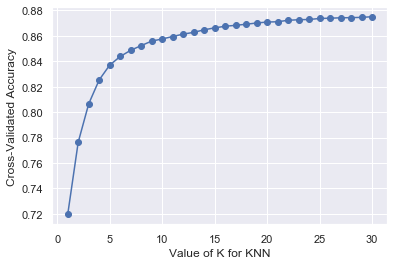

In [2547]:
# use grid serach to get the best k
g, k = knn_k_grid_search(X_train, y_train, n_CV)

Training cross validation scores:
roc_uac: 0.8748716158030119
accuracy: 0.7884501408615252
f1: 0.787784225568272
precision: 0.7890856278058763
recall: 0.7867369255837872


Testing cross validation scores:
roc_uac: 0.8721129646171313
accuracy: 0.7767586437288063
f1: 0.7796420916205387
precision: 0.775589645382671
recall: 0.7841333535231172


classification report:
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      1998
           1       0.79      0.78      0.79      2029

    accuracy                           0.79      4027
   macro avg       0.79      0.79      0.79      4027
weighted avg       0.79      0.79      0.79      4027

confusion matrix:
[[1588  410]
 [ 444 1585]]
mean squared error:
0.21206853737273404
r2 scores:
0.15167557897966966
ROC AUC Score: 
0.8781393517716829



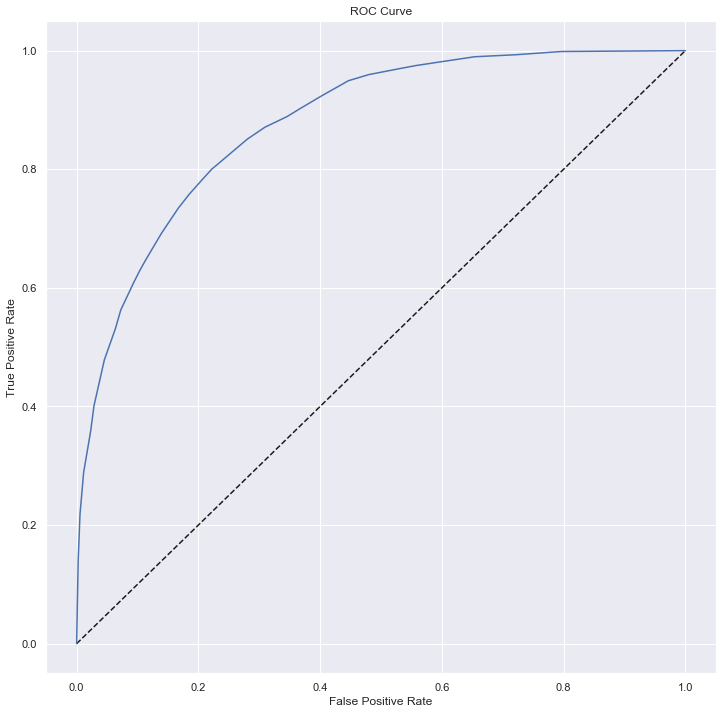

In [2435]:
knn = KNeighborsClassifier(n_neighbors=k)
print('Training cross validation scores:')
get_cross_val_scores(knn, X_train, y_train, n_CV=10);
print('Testing cross validation scores:')
get_cross_val_scores(knn, X_test, y_test, n_CV=4);
run_train_testing_split(knn, X_train, X_test, y_train, y_test)

### Exam learninig performance¶ 

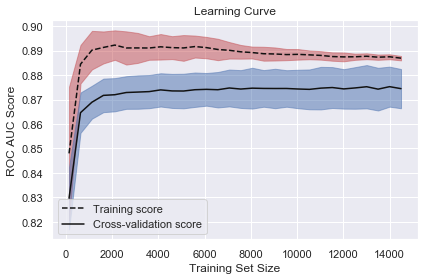

In [2548]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=k), X_train, y_train)

Both training and testing curve keep flat after size>2000.  The varaince is big for testing curve.

### Model of data set 1 performs better than data set 2 and 3 

# Can we predict player hand based on the historic match data?

Change response y to player_hand_flag and run through the KNN models

#### Data Set 1 

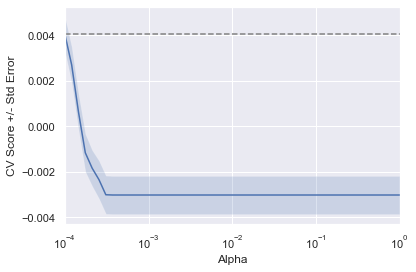

In [2436]:
# use percentage to re-scale the date
# run Lasso to find out the best alpha
model_columns=['sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct',
               'bpFaced','bpSaved', 'player_age', 'player_rank', 'svpt_std_var', 'bpSaved_pct']

names= df[model_columns].columns
X = df[model_columns].values
y=df['player_hand_flag'].values
plot_lasso_alpha(X,y)
plt.show()

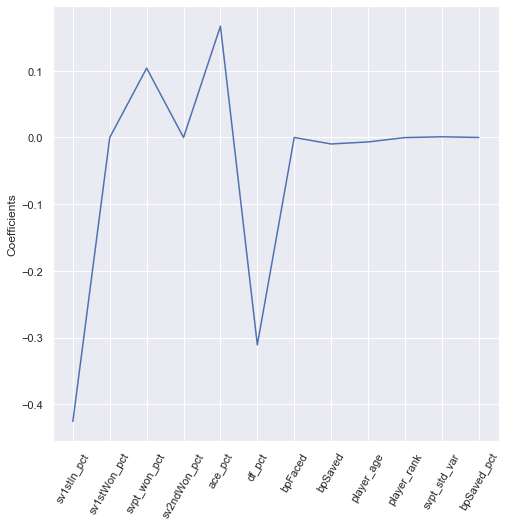

In [2325]:
plot_lasso_features(names, X, y, 0.0005)

In [2549]:
# split data into train and testing set
model_columns=['sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct',
               'bpFaced','bpSaved', 'player_age', 'player_rank', 'svpt_std_var', 'bpSaved_pct']
#model_columns=['sv1stIn_pct','svpt_won_pct', 'bpSaved_pct']
names= df[model_columns].columns
X = df[model_columns].values
y=df['player_hand_flag'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = p_test_size , random_state=p_random_state)  

### Choose the best n_neighbors 

In [2455]:
# use cross val search best k from the list of k
# alternative way to ge tbest k
# k_range, k_scores = knn_cross_val_k_search(X_train, y_train, n_CV)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}

Mean Test Score
0.5990076597344397
{'n_neighbors': 26}
0.6088671714694668


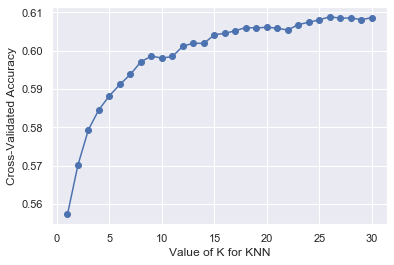

In [2550]:
# use grid serach to get the best k
g, k = knn_k_grid_search(X_train, y_train, n_CV)

Training cross validation scores:
roc_uac: 0.6088699164144955
accuracy: 0.5759096525586767
f1: 0.5313766426786316
precision: 0.5919721137844098
recall: 0.48213245726535436


Testing cross validation scores:
roc_uac: 0.5978997188427005
accuracy: 0.5783440288425028
f1: 0.551135828150329
precision: 0.5958423998528972
recall: 0.5130331203687948


classification report:
              precision    recall  f1-score   support

         0.0       0.56      0.67      0.61      1994
         1.0       0.60      0.49      0.54      2033

    accuracy                           0.58      4027
   macro avg       0.58      0.58      0.58      4027
weighted avg       0.58      0.58      0.58      4027

confusion matrix:
[[1335  659]
 [1031 1002]]
mean squared error:
0.41966724608889994
r2 scores:
-0.6788264449028341
ROC AUC Score: 
0.6158655504141545



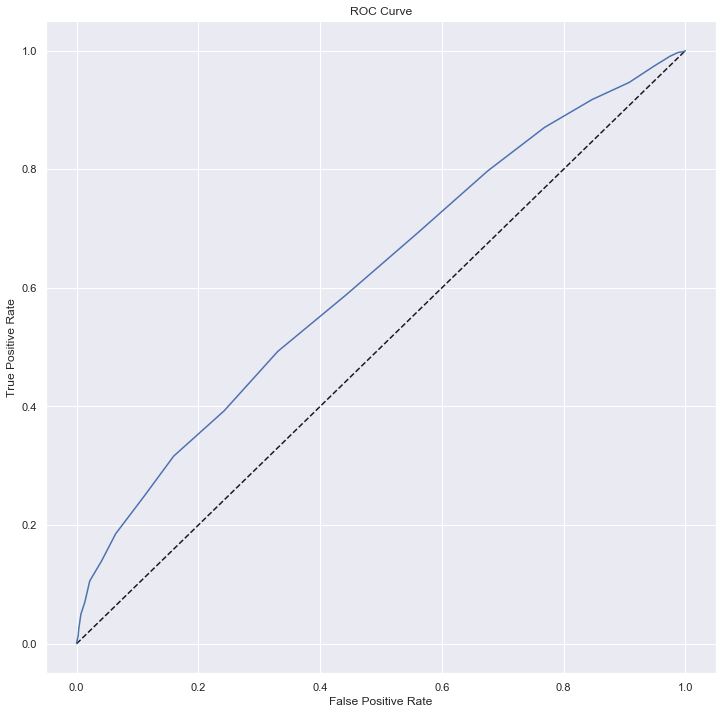

In [2440]:
knn = KNeighborsClassifier(n_neighbors=k)
print('Training cross validation scores:')
get_cross_val_scores(knn, X_train, y_train, n_CV=10);
print('Testing cross validation scores:')
get_cross_val_scores(knn, X_test, y_test, n_CV=4);
run_train_testing_split(knn, X_train, X_test, y_train, y_test)

### Exam learninig performance 

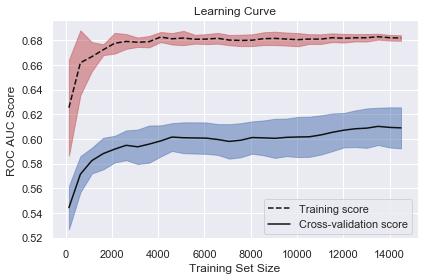

In [2551]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=k), X_train, y_train)

•	The score of both training and testing is lower than 70%. Both training and testing curve keep flat after size>2000

•	The testing curve shows higher variability than training.  

•	The gap between training score and Cross-validation score is big and are not decreasing even the data size increases.


### Data Set 2 

In [2552]:
# Data set 2
model_columns_set2=['sv1stIn','sv1stWon','svpt','sv2ndWon','ace','df', 'SvGms',
               'sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct','bpSaved_pct',
               'bpFaced','bpSaved', 
               'player_age', 'player_rank', 'player_rank_points','player_ht',
               'svpt_std_var']

names_set1= df[model_columns_set2].columns
X2 = df[model_columns_set2].values
y2 = df['player_hand_flag'].values


X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = p_test_size , random_state=p_random_state)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}

Mean Test Score
0.6204629661240567
{'n_neighbors': 7}
0.6286531349525687


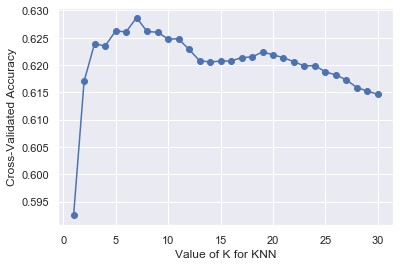

In [2553]:
# use grid serach to get the best k
g, k = knn_k_grid_search(X2_train, y2_train, n_CV)

Training cross validation scores:
roc_uac: 0.6286563956592839
accuracy: 0.592178321733549
f1: 0.5697730264439516
precision: 0.6014012467774117
recall: 0.5413939022199091


Testing cross validation scores:
roc_uac: 0.5808468028918365
accuracy: 0.5562506498578867
f1: 0.5483504373534586
precision: 0.5639268362576367
recall: 0.5337014448586853


classification report:
              precision    recall  f1-score   support

         0.0       0.58      0.65      0.62      1994
         1.0       0.62      0.55      0.58      2033

    accuracy                           0.60      4027
   macro avg       0.60      0.60      0.60      4027
weighted avg       0.60      0.60      0.60      4027

confusion matrix:
[[1301  693]
 [ 924 1109]]
mean squared error:
0.4015396076483735
r2 scores:
-0.6063090895904633
ROC AUC Score: 
0.6351447357320362



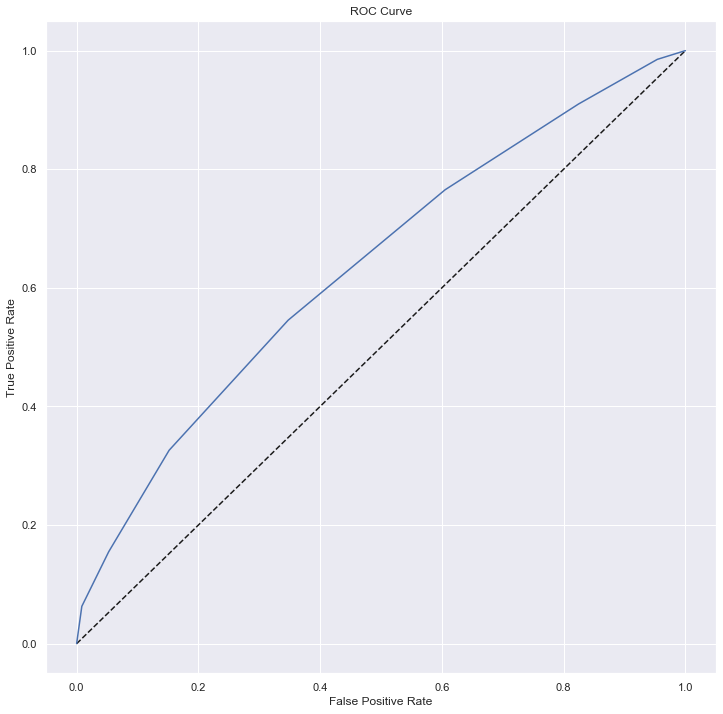

In [2443]:
knn2 = KNeighborsClassifier(n_neighbors=k)
print('Training cross validation scores:')
get_cross_val_scores(knn2, X2_train, y2_train, n_CV=10);
print('Testing cross validation scores:')
get_cross_val_scores(knn2, X2_test, y2_test, n_CV=4);
run_train_testing_split(knn2, X2_train, X2_test, y2_train, y2_test)

# Logictics Regression

In [2336]:
def choose_LR_params(X_train, X_test, y_train, y_test):

    # load libraries
    from sklearn import decomposition
    from sklearn.pipeline import Pipeline
    #from sklearn.model_selection import GridSearchCV, cross_val_score
    #from sklearn.preprocessing import StandardScaler

    # Create an scaler object
    sc = StandardScaler()

    # Create a pca object
    pca = decomposition.PCA()

    # Create a logistic regression object with an L2 penalty
    logistic = LogisticRegression()

    # Create a pipeline of three steps. First, standardize the data.
    # Second, tranform the data with PCA.
    # Third, train a logistic regression on the data.
    pipe = Pipeline(steps=[('sc', sc),
                           ('pca', pca),
                           ('logistic', logistic)])

    # Create Parameter Space
    # Create a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
    n_components = list(range(1,X.shape[1]+1,1))
    # Create a list of values of the regularization parameter
    C = np.logspace(-4, 4, 50)
    # Create a list of options for the regularization penalty
    penalty = ['l1', 'l2']
    # Create a list of solver
    ##solver=['lbfgs','liblinear']
    # Create a dictionary of all the parameter options 
    # Note has you can access the parameters of steps of a pipeline by using '__’
    parameters = dict(pca__n_components=n_components,
                      logistic__C=C,
                      logistic__penalty=penalty
                      #, logistic__solver=solver
                      )

    # Conduct Parameter Optmization With Pipeline
    # Create a grid search object
    clf = GridSearchCV(pipe, parameters)

    # Fit the grid search
    clf.fit(X_train, y_train)
    # View The Best Parameters
    print('Best Penalty:', clf.best_estimator_.get_params()['logistic__penalty'])
    print('Best C:', clf.best_estimator_.get_params()['logistic__C'])
    print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
    print(); print(clf.best_estimator_.get_params()['logistic'])

    # Use Cross Validation To Evaluate Model
    CV_Result = cross_val_score(clf, X_test, y_test, cv=4, n_jobs=-1)
    print(); print(CV_Result)
    print(); print(CV_Result.mean())
    print(); print(CV_Result.std())
    print()
    ##run_train_testing_split(logisticreg, X_train, X_test, y_train, y_test)

### Predict won_flag 

Training cross validation scores:
roc_uac: 0.8830343592645133
accuracy: 0.7982006532639234
f1: 0.7994925760389562
precision: 0.7945557903633589
recall: 0.8049217822850361


Testing cross validation scores:
roc_uac: 0.8812446295457226
accuracy: 0.7938823432256824
f1: 0.797100542951782
precision: 0.7844530499434633
recall: 0.8102210151787685


classification report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      2014
           1       0.79      0.80      0.80      2013

    accuracy                           0.79      4027
   macro avg       0.79      0.79      0.79      4027
weighted avg       0.79      0.79      0.79      4027

confusion matrix:
[[1580  434]
 [ 394 1619]]
mean squared error:
0.2056121182021356
r2 scores:
0.17755147647540215
ROC AUC Score: 
0.8851019761816318



C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


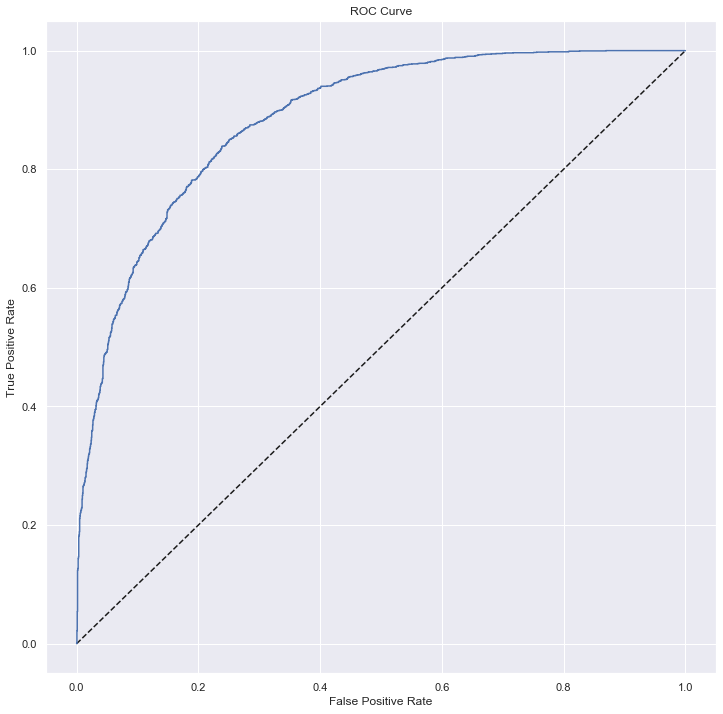

In [2554]:
# Logictics Regression
model_columns=['sv1stWon_pct','sv2ndWon_pct', 'svpt_won_pct','ace_pct','df_pct','bpSaved_pct']
X=df[model_columns]
y=df['won_flag']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=p_test_size,  random_state= p_random_state, stratify=y) 
logisticreg = LogisticRegression()

print('Training cross validation scores:')
get_cross_val_scores(logisticreg, X_train, y_train, n_CV=10);
print('Testing cross validation scores:')
get_cross_val_scores(logisticreg, X_test, y_test, n_CV=4);
run_train_testing_split(logisticreg, X_train, X_test, y_train, y_test)

### Exam learninig performance¶ 

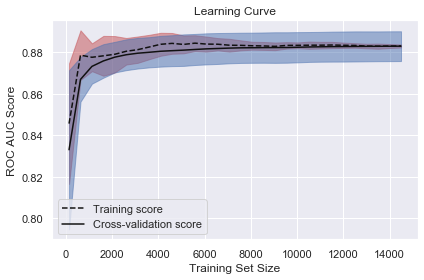

In [2555]:
#plot_learning_curve(LogisticRegression(), X_train, y_train)
plot_learning_curve(logisticreg, X_train, y_train)

### Predict player hand 

In [2448]:
# Data set 1
model_columns_set1=['sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct',
               'bpFaced','bpSaved', 'player_age', 'player_rank', 'svpt_std_var', 'bpSaved_pct']

names_set1= df[model_columns_set1].columns
X1 = df[model_columns_set1].values
y1 = df['player_hand_flag'].values


X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = p_test_size , random_state=p_random_state)

# split training set into training and validation set for hyperparameter tuning
X1_train_p, X1_val_p, y1_train_p, y1_val_p = train_test_split(X1_train, y1_train, test_size = p_test_size , random_state=p_random_state)

In [2340]:
# find the best C
choose_LR_params(X1_train_p, X1_val_p, y1_train_p, y1_val_p)

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Best Penalty: l2
Best C: 0.0009540954763499944
Best Number Of Components: 5

LogisticRegression(C=0.0009540954763499944, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

[0.5483871  0.53598015 0.53664596 0.55721393]

0.5445567846846865

0.008817800358831226



Training cross validation scores:
roc_uac: 0.538524067824544
accuracy: 0.5297746122555529
f1: 0.5210460739370506
precision: 0.5295950467817435
recall: 0.5128856031176621


Testing cross validation scores:
roc_uac: 0.5228033792006758
accuracy: 0.5172552159066847
f1: 0.5496709411513794
precision: 0.51980748223067
recall: 0.5833732964126045


classification report:
              precision    recall  f1-score   support

         0.0       0.52      0.55      0.53      1994
         1.0       0.53      0.50      0.51      2033

    accuracy                           0.52      4027
   macro avg       0.52      0.52      0.52      4027
weighted avg       0.52      0.52      0.52      4027

confusion matrix:
[[1090  904]
 [1018 1015]]
mean squared error:
0.4772783709957785
r2 scores:
-0.9092925604161226
ROC AUC Score: 
0.5361482874595256



C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


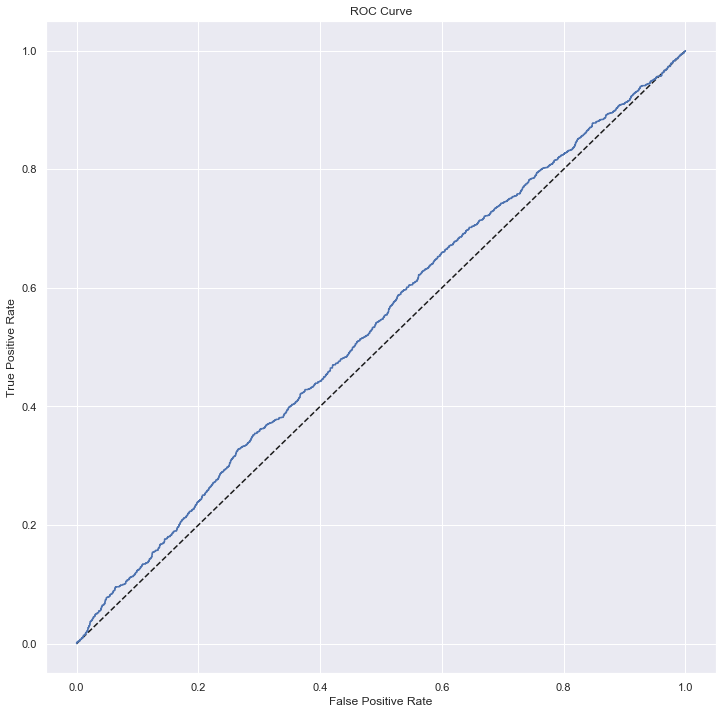

In [2449]:
logisticreg_t = LogisticRegression(C=0.0009540954763499944, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

print('Training cross validation scores:')
get_cross_val_scores(logisticreg_t, X1_train, y1_train, n_CV=10);
print('Testing cross validation scores:')
get_cross_val_scores(logisticreg_t, X1_test, y1_test, n_CV=4);
run_train_testing_split(logisticreg_t, X1_train, X1_test, y1_train, y1_test)

In [2453]:
# Data set 2
model_columns_set2=['sv1stIn','sv1stWon','svpt','sv2ndWon','ace','df', 'SvGms',
               'sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct','bpSaved_pct',
               'bpFaced','bpSaved', 
               'player_age', 'player_rank', 'player_rank_points','player_ht',
               'svpt_std_var']

names_set2= df[model_columns_set2].columns
X2 = df[model_columns_set2].values
y2 = df['player_hand_flag'].values


X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = p_test_size , random_state=p_random_state)
# split training set into training and validation set for hyperparameter tuning
X2_train_p, X2_val_p, y2_train_p, y2_val_p = train_test_split(X2_train, y2_train, test_size = p_test_size , random_state=p_random_state)

In [2452]:
# get best C
choose_LR_params(X2_train_p, X2_val_p, y2_train_p, y2_val_p)

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Best Penalty: l2
Best C: 0.0009540954763499944
Best Number Of Components: 5

LogisticRegression(C=0.0009540954763499944, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

[0.53970223 0.53473945 0.51925466 0.55472637]

0.5371056784723026

0.012663813976444038



Training cross validation scores:
roc_uac: 0.5714500670494772
accuracy: 0.5500138885337158
f1: 0.5479256081936281
precision: 0.548996505668619
recall: 0.5469907622534895


Testing cross validation scores:
roc_uac: 0.5693530373295707
accuracy: 0.5495453479255299
f1: 0.5785750116633069
precision: 0.5481518698839434
recall: 0.612889253283418




C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


classification report:
              precision    recall  f1-score   support

         0.0       0.56      0.58      0.57      1994
         1.0       0.57      0.55      0.56      2033

    accuracy                           0.57      4027
   macro avg       0.57      0.57      0.57      4027
weighted avg       0.57      0.57      0.57      4027

confusion matrix:
[[1160  834]
 [ 910 1123]]
mean squared error:
0.4330767320586044
r2 scores:
-0.7324694200654098
ROC AUC Score: 
0.5811966149308723



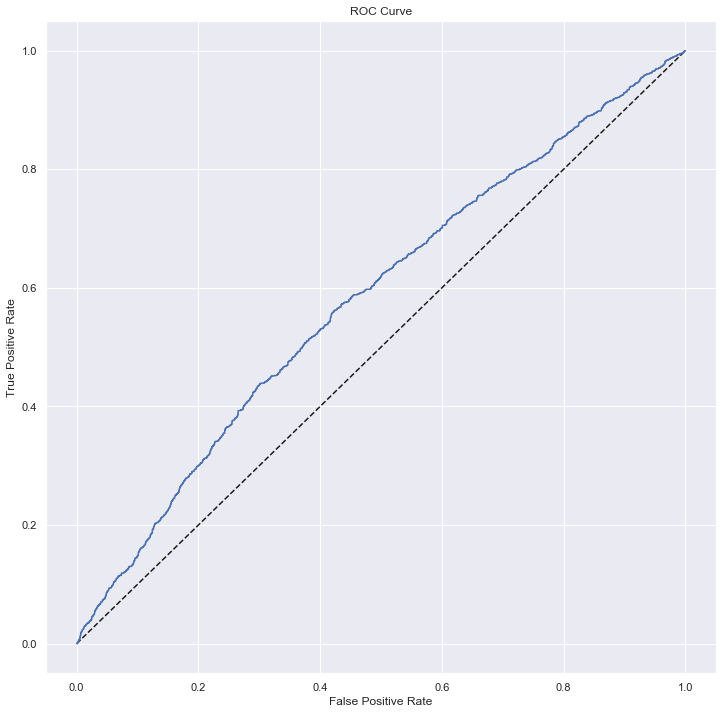

In [2454]:
logisticreg_t2 = LogisticRegression(C=0.0009540954763499944, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

print('Training cross validation scores:')
get_cross_val_scores(logisticreg_t2, X2_train, y2_train, n_CV=10);
print('Testing cross validation scores:')
get_cross_val_scores(logisticreg_t2, X2_test, y2_test, n_CV=4);
run_train_testing_split(logisticreg_t2, X2_train, X2_test, y2_train, y2_test)

### Logistics Regression algorithm doesn't fit into this ATP data set 

# Random Forest

## Predict won_flag 

In [2457]:
model_columns=['sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct',
               'bpFaced','bpSaved', 'player_age', 'player_rank', 'svpt_std_var', 'bpSaved_pct']
names= df[model_columns].columns

X=df[model_columns]
y=df['won_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=p_test_size,  random_state= p_random_state, stratify=y)

# split training set into training and validation set for hyperparameter tuning
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_train, y_train, test_size = p_test_size , random_state=p_random_state)


In [2458]:
# randm forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [2459]:
y_pred = rf.predict(X_test)

In [2460]:
# use AUC (Area Under Curve) as the evaluation metric
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('roc auc:', roc_auc)
print()
print('classification report:')
print(classification_report(y_test, y_pred))
print('confusion matrix:')
print(confusion_matrix(y_test, y_pred))

roc auc: 0.7772433501998676

classification report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      2014
           1       0.80      0.74      0.77      2013

    accuracy                           0.78      4027
   macro avg       0.78      0.78      0.78      4027
weighted avg       0.78      0.78      0.78      4027

confusion matrix:
[[1648  366]
 [ 531 1482]]


### Exam feature importane

In [2461]:
# randon forest
# Feature Importance

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,  random_state=42, stratify=y) 

features = model_columns # Store Feature Names

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, n_jobs=-1) # 1000 Trees
clf.fit(X_train, y_train)

for feature in zip(features, clf.feature_importances_): # Print each feature with gini score.
    print(feature)

('sv1stIn_pct', 0.0527394513282467)
('sv1stWon_pct', 0.11007642758373118)
('svpt_won_pct', 0.23997242783059763)
('sv2ndWon_pct', 0.06139384937232547)
('ace_pct', 0.055241350752666375)
('df_pct', 0.039609249968851803)
('bpFaced', 0.08790181349216751)
('bpSaved', 0.033794045501578523)
('player_age', 0.06976416148736311)
('player_rank', 0.08260117569641051)
('svpt_std_var', 0.06977933474980787)
('bpSaved_pct', 0.09712671223625344)


## Choose Model Parameters
### N_estimators

n_estimators represents the number of trees in the forest. Usually the higher the number of trees the better to learn the data. However, adding a lot of trees can slow down the training process considerably, therefore we do a parameter search to find the sweet spot.

In [2462]:
def choose_N_estimators(X_train, X_test, y_train, y_test):
    # n_estimators represents the number of trees in the forest
    n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
    train_results = []
    test_results = []
    
    for estimator in n_estimators:
        rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    
        rf.fit(X_train, y_train)
        train_pred = rf.predict(X_train)
    
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
    
        y_pred = rf.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
    
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
    line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('n_estimators')
    plt.show()

### max_depth 
max_depth represents the depth of each tree in the forest. The deeper the tree, the more splits it has and it captures more information about the data. We fit each decision tree with depths ranging from 1 to 32 and plot the training and test errors.

In [2463]:
def choose_max_depth(X_train, X_test, y_train, y_test):
    # max_depth
    max_depths = np.linspace(1, 32, 32, endpoint=True)
    train_results = []
    test_results = []
    for max_depth in max_depths:
        rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
        rf.fit(X_train, y_train)
        train_pred = rf.predict(X_train)
    
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = rf.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
        
    #from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
    line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('Tree depth')
    plt.show()

### min_samples_split

min_samples_split represents the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node. When we increase this parameter, each tree in the forest becomes more constrained as it has to consider more samples at each node. Here we will vary the parameter from 10% to 100% of the samples

In [2464]:
def choose_min_samples_split (X_train, X_test, y_train, y_test):
    # min_samples_split
    min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)

    train_results = []
    test_results = []

    for min_samples_split in min_samples_splits:
        rf = RandomForestClassifier(min_samples_split=min_samples_split)
    
        rf.fit(X_train, y_train)
        train_pred = rf.predict(X_train)
    
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
    
        y_pred = rf.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
    
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
    line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('min samples split')
    plt.show()

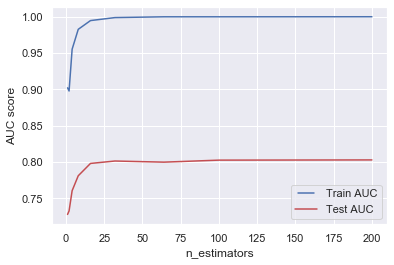

In [2465]:
choose_N_estimators(X_train_p, X_test_p, y_train_p, y_test_p)

In [2355]:
print('From the above plot, we can stop at 30 trees')

From the above plot, we can stop at 30 trees


C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

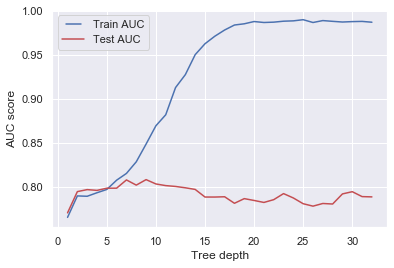

In [2466]:
choose_max_depth(X_train_p, X_test_p, y_train_p, y_test_p)

We see that our model overfits for large depth values. We choose max_depth = 8

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

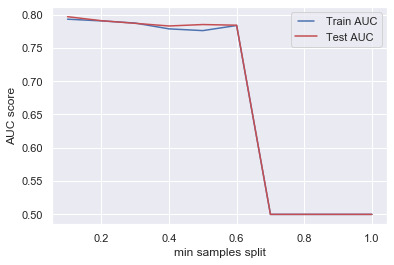

In [2467]:
choose_min_samples_split (X_train_p, X_test_p, y_train_p, y_test_p)

Use default value 2.

Training cross validation scores:
roc_uac: 0.8949766292841023
accuracy: 0.8021749221654414
f1: 0.8030041728081543
precision: 0.7996710183296465
recall: 0.806659371484056


Testing cross validation scores:
roc_uac: 0.8874134483120796
accuracy: 0.7968696285857308
f1: 0.7984664298938559
precision: 0.7923964783208282
recall: 0.804763679825807


classification report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      2014
           1       0.80      0.80      0.80      2013

    accuracy                           0.80      4027
   macro avg       0.80      0.80      0.80      4027
weighted avg       0.80      0.80      0.80      4027

confusion matrix:
[[1603  411]
 [ 409 1604]]
mean squared error:
0.2036255276881053
r2 scores:
0.1854978390215335
ROC AUC Score: 
0.8941801330083355



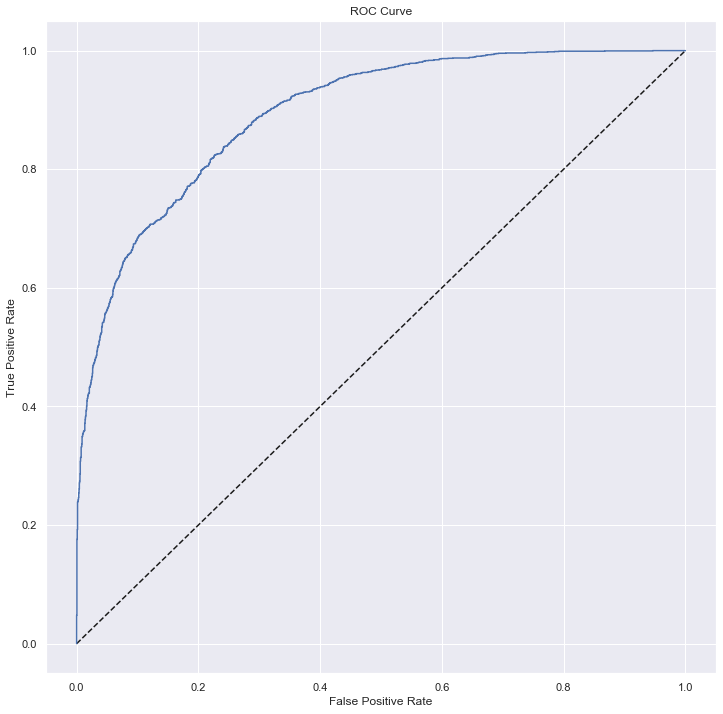

In [2468]:
# randm forest
# Using the actual data

clf = RandomForestClassifier(n_estimators=30,  random_state=50, max_features='auto', n_jobs=-1, max_depth=8)

print('Training cross validation scores:')
get_cross_val_scores(clf, X_train, y_train, n_CV=10);
print('Testing cross validation scores:')
get_cross_val_scores(clf, X_test, y_test, n_CV=4);
run_train_testing_split(clf, X_train, X_test, y_train, y_test)

### Exam learninig performance¶ 

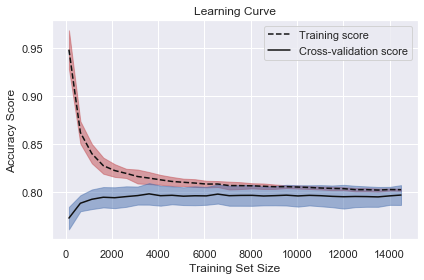

In [2360]:
plot_learning_curve(clf, X_train, y_train)

•	When training set size less than 4000, the plot shows high bias. 

•	When the training size increases, the variance gets smaller. More training data may not help. 

•	Training score and Cross-validation score are converging when the training set size increases, and the accuracy score is at 0.80. 

•	The testing curve shows higher variability than training. The variability of both training and testing are not narrow.

## Predict player hand

### Data set 1 of selected predictor variables 

In [2537]:
model_columns=['sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct',
               'bpFaced','bpSaved', 'player_age', 'player_rank', 'svpt_std_var', 'bpSaved_pct']
names= df[model_columns].columns

X=df[model_columns]
y=df['player_hand_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=p_test_size,  random_state= p_random_state, stratify=y)

# split training set into training and validation set for hyperparameter tuning
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_train, y_train, test_size = p_test_size , random_state=p_random_state)


In [2470]:
# randm forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [2471]:
y_pred = rf.predict(X_test)

In [2472]:
# use AUC (Area Under Curve) as the evaluation metric
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('roc auc:', roc_auc)
print()
print('classification report:')
print(classification_report(y_test, y_pred))
print('confusion matrix:')
print(confusion_matrix(y_test, y_pred))

roc auc: 0.5835330036984033

classification report:
              precision    recall  f1-score   support

         0.0       0.57      0.70      0.63      2014
         1.0       0.61      0.47      0.53      2013

    accuracy                           0.58      4027
   macro avg       0.59      0.58      0.58      4027
weighted avg       0.59      0.58      0.58      4027

confusion matrix:
[[1402  612]
 [1065  948]]


In [2473]:
# randon forest
# Feature Importance

features = model_columns # Store Feature Names

clf = RandomForestClassifier(n_estimators=100,  random_state=50, n_jobs=-1) # 100 Trees
clf.fit(X_train, y_train)

for feature in zip(features, clf.feature_importances_): # Print each feature with gini score.
    print(feature)

('sv1stIn_pct', 0.08621440468939706)
('sv1stWon_pct', 0.0756044891914313)
('svpt_won_pct', 0.07456037561058719)
('sv2ndWon_pct', 0.07088285680419874)
('ace_pct', 0.08068944621169702)
('df_pct', 0.06273685223688201)
('bpFaced', 0.05376392790958112)
('bpSaved', 0.04412047193309118)
('player_age', 0.14127131043916663)
('player_rank', 0.15997264270544884)
('svpt_std_var', 0.08981392759321688)
('bpSaved_pct', 0.06036929467530211)


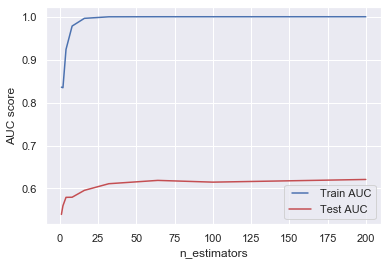

In [2474]:
choose_N_estimators(X_train_p, X_test_p, y_train_p, y_test_p)

From the plot, we can stop at 15 trees

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

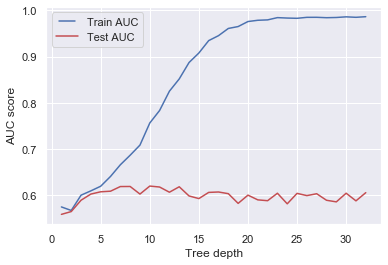

In [2475]:
choose_max_depth(X_train_p, X_test_p, y_train_p, y_test_p)

We see that the model overfits for large depth values. Choose 6, 7 or 8

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

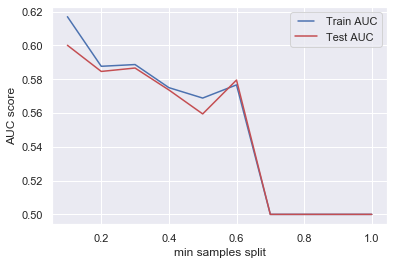

In [2476]:
choose_min_samples_split (X_train_p, X_test_p, y_train_p, y_test_p)

Increase this value can cause underfitting.  Use default value 2.

Training cross validation scores:
roc_uac: 0.6608640720922462
accuracy: 0.6071397517584844
f1: 0.5521466616289457
precision: 0.6427383201166743
recall: 0.4844199559206571


Testing cross validation scores:
roc_uac: 0.6165430647691568
accuracy: 0.57611780335468
f1: 0.539237882716989
precision: 0.5906414091086848
recall: 0.49627926883145573


classification report:
              precision    recall  f1-score   support

         0.0       0.57      0.74      0.64      2014
         1.0       0.63      0.44      0.52      2013

    accuracy                           0.59      4027
   macro avg       0.60      0.59      0.58      4027
weighted avg       0.60      0.59      0.58      4027

confusion matrix:
[[1486  528]
 [1119  894]]
mean squared error:
0.4089893220759871
r2 scores:
-0.635957389184798
ROC AUC Score: 
0.6401381339071606



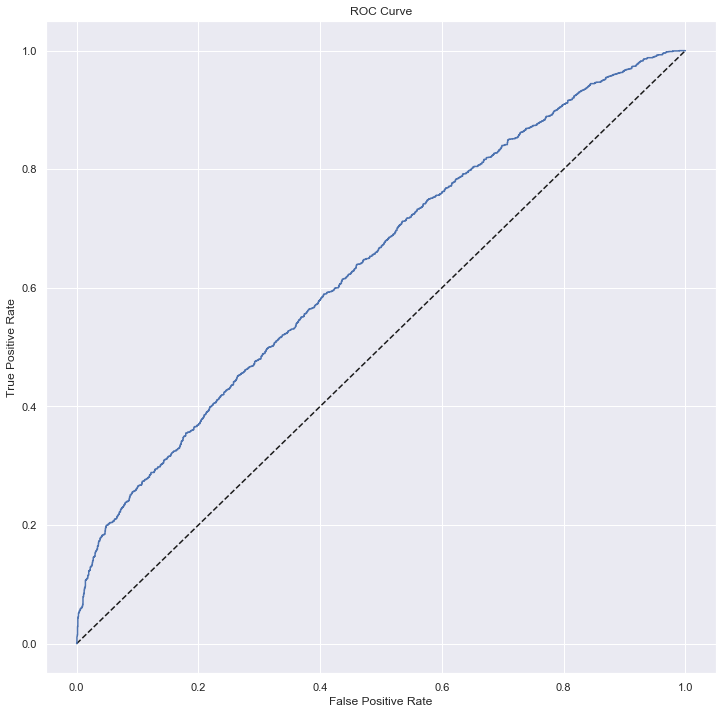

In [2538]:
# randm forest
# Using the actual data

clf = RandomForestClassifier(n_estimators=15,  random_state=50, max_features='auto', n_jobs=-1, max_depth=6)

print('Training cross validation scores:')
get_cross_val_scores(clf, X_train, y_train, n_CV=10);
print('Testing cross validation scores:')
get_cross_val_scores(clf, X_test, y_test, n_CV=4);
run_train_testing_split(clf, X_train, X_test, y_train, y_test)

### Exam learninig performance¶ 

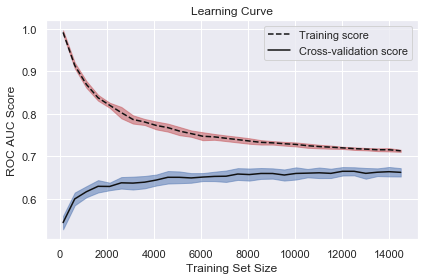

In [2539]:
plot_learning_curve(clf, X_train, y_train)


•	When the training size is increasing, the variance is getting smaller. Get more training data may help to decease. 

•	Training score and Cross-validation score are converging when the training set size increases, but the AUC score is low at 0.70. 

•	The testing curve shows higher variability than training. The variability of both training and testing are narrow.


### Data set 2 of selected predictor variables

Will apply more data to predict play hand

In [2372]:
df.columns

Index(['Unnamed: 0', 'tourney_id', 'tourney_name', 'surface', 'tourney_level',
       'tourney_date', 'match_num', 'player_id', 'player_name', 'player_hand',
       'player_ht', 'player_ioc', 'player_age', 'score', 'best_of', 'round',
       'minutes', 'ace', 'df', 'svpt', 'sv1stIn', 'sv1stWon', 'sv2ndWon',
       'SvGms', 'bpSaved', 'bpFaced', 'player_rank', 'player_rank_points',
       'ace_pct', 'df_pct', 'sv1stIn_pct', 'sv2ndIn_pct', 'sv1stWon_pct',
       'sv2ndWon_pct', 'GmsWon', 'GmsLoss', 'year', 'opponent_id',
       'opponent_name', 'won_flag', 'player_age_bucket', 'player_hand_flag',
       'surface_id', 'tourney_level_id', 'player_rank_group', 'svpt_won_pct',
       'svpt_std_var', 'bpSaved_pct'],
      dtype='object')

In [2534]:
model_columns=['sv1stIn','sv1stWon','svpt','sv2ndWon','ace','df', 'SvGms',
               'sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct','bpSaved_pct',
               'bpFaced','bpSaved', 
               'player_age', 'player_rank', 'player_rank_points','player_ht',
               'svpt_std_var']
names= df[model_columns].columns

X=df[model_columns]
y=df['player_hand_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=p_test_size,  random_state= p_random_state, stratify=y)

# split training set into training and validation set for hyperparameter tuning
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_train, y_train, test_size = p_test_size , random_state=p_random_state)


In [2479]:
# randm forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [2480]:
y_pred = rf.predict(X_test)

In [2481]:
# use AUC (Area Under Curve) as the evaluation metric
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6997526258071295

In [2482]:
# randon forest
# Feature Importance

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,  random_state=42, stratify=y) 

features = model_columns # Store Feature Names

clf = RandomForestClassifier(n_estimators=100,  random_state=50, n_jobs=-1) # 100 Trees
clf.fit(X_train, y_train)

for feature in zip(features, clf.feature_importances_): # Print each feature with gini score.
    print(feature)

('sv1stIn', 0.04074354108452651)
('sv1stWon', 0.037767338353996385)
('svpt', 0.04071903485418204)
('sv2ndWon', 0.03514080428875224)
('ace', 0.03491909124490318)
('df', 0.02543789566452854)
('SvGms', 0.025085243386944817)
('sv1stIn_pct', 0.047005609724083054)
('sv1stWon_pct', 0.03901150111137431)
('svpt_won_pct', 0.039139461102145154)
('sv2ndWon_pct', 0.03695021859376171)
('ace_pct', 0.0383710487097263)
('df_pct', 0.029562456545030466)
('bpSaved_pct', 0.033788827339461876)
('bpFaced', 0.029596100513190376)
('bpSaved', 0.025564766495660134)
('player_age', 0.09191232954044)
('player_rank', 0.09289839227839124)
('player_rank_points', 0.09748727914798999)
('player_ht', 0.118031075273451)
('svpt_std_var', 0.04086798474746065)


### Find the best params

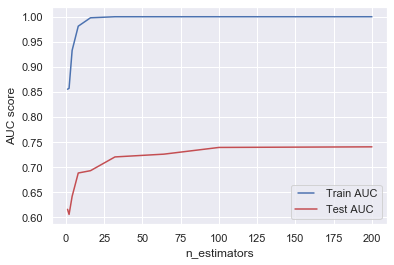

In [2483]:
choose_N_estimators(X_train_p, X_test_p, y_train_p, y_test_p)

We can stop at 100 trees

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

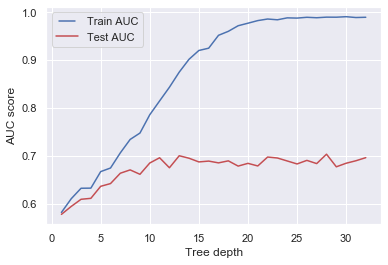

In [2379]:
choose_max_depth(X_train_p, X_test_p, y_train_p, y_test_p)

We will choose 8 as max depth

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

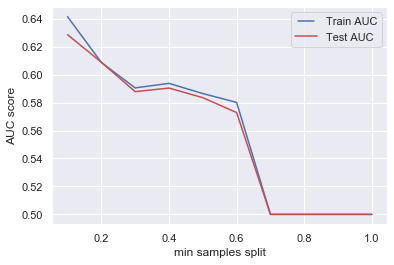

In [2484]:
choose_min_samples_split (X_train_p, X_test_p, y_train_p, y_test_p)

Training cross validation scores:
roc_uac: 0.7759924407888464
accuracy: 0.6968031806915821
f1: 0.6708774801289781
precision: 0.7335955818926404
recall: 0.6184052833561949


Testing cross validation scores:
roc_uac: 0.724773645554319
accuracy: 0.654341148221091
f1: 0.6166897399572476
precision: 0.6930226234631979
recall: 0.5558849285240934


classification report:
              precision    recall  f1-score   support

         0.0       0.67      0.77      0.71      2014
         1.0       0.72      0.61      0.66      2013

    accuracy                           0.69      4027
   macro avg       0.69      0.69      0.69      4027
weighted avg       0.69      0.69      0.69      4027

confusion matrix:
[[1542  472]
 [ 776 1237]]
mean squared error:
0.3099081201887261
r2 scores:
-0.23963255719649545
ROC AUC Score: 
0.7671996471791351



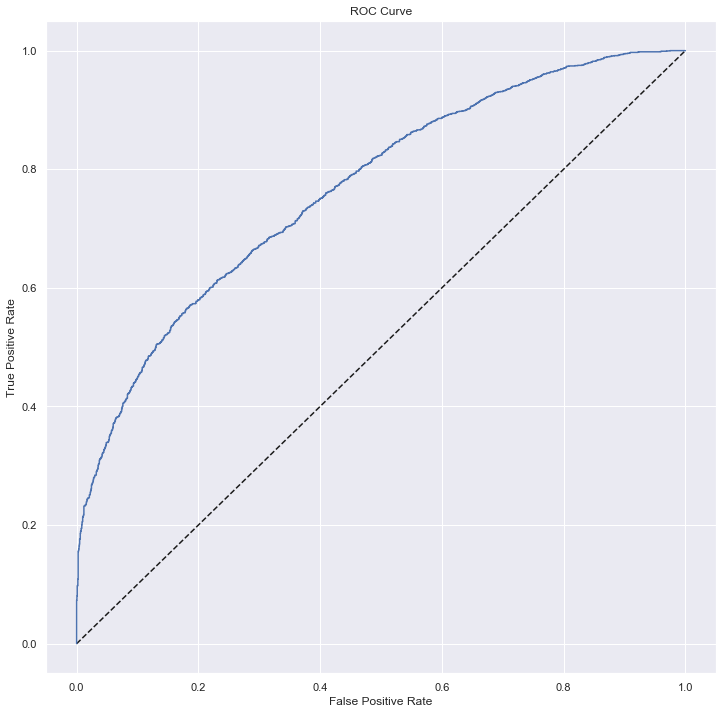

In [2535]:
# randm forest
# Using the actual data

clf = RandomForestClassifier(n_estimators=100,  random_state=50, max_features='auto', n_jobs=-1, max_depth=8)

print('Training cross validation scores:')
get_cross_val_scores(clf, X_train, y_train, n_CV=10);
print('Testing cross validation scores:')
get_cross_val_scores(clf, X_test, y_test, n_CV=4);
run_train_testing_split(clf, X_train, X_test, y_train, y_test)

### Exam learninig performance¶ 

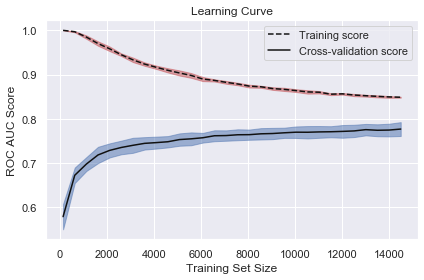

In [2536]:
plot_learning_curve(clf, X_train, y_train)

## Gradient Boosting 

#### Data Set 2 

In [2531]:
model_columns=['sv1stIn','sv1stWon','svpt','sv2ndWon','ace','df', 'SvGms',
               'sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct','bpSaved_pct',
               'bpFaced','bpSaved', 
               'player_age', 'player_rank', 'player_rank_points','player_ht',
               'svpt_std_var']
names= df[model_columns].columns

X=df[model_columns]
y=df['player_hand_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=p_test_size,  random_state= p_random_state, stratify=y)

# split training set into training and validation set for hyperparameter tuning
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_train, y_train, test_size = p_test_size , random_state=p_random_state)

Ffirst fit a gradient boosting classifier with default parameters to get a baseline idea of the performance

In [2487]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [2488]:
y_pred = model.predict(X_test)

In [2489]:
# Use AUC(Area Under Curve) as the evaluation metric
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7059658397180986

### Functions to tune params 

#### learning_rate 

In [2490]:
def choose_GB_learning_rate (X_train, X_test, y_train, y_test):
    learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
    train_results = []
    test_results = []
    
    for eta in learning_rates:
        model = GradientBoostingClassifier(learning_rate=eta)
        model.fit(X_train, y_train)
        
        # trainng
        train_pred = model.predict(X_train)        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        
        # testing
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
        
    #from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(learning_rates, train_results, 'b', label="Train AUC")
    line2, = plt.plot(learning_rates, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('learning rate')
    plt.show()

#### n_estimators 

In [2491]:
def choose_GB_n_estimators (X_train, X_test, y_train, y_test):
    n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
    train_results = []
    test_results = []
    for estimator in n_estimators:
        model = GradientBoostingClassifier(n_estimators=estimator)
        model.fit(X_train, y_train)
        
        # trainng
        train_pred = model.predict(X_train)        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        
        # testing
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
        
    #from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
    line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('n_estimators')
    plt.show()

#### ma_depth 

In [2492]:
def choose_GB_max_depth (X_train, X_test, y_train, y_test):
    max_depths = np.linspace(1, 32, 32, endpoint=True)
    train_results = []
    test_results = []
    for max_depth in max_depths:
        model = GradientBoostingClassifier(max_depth=max_depth)
        model.fit(X_train, y_train)
        
        # trainng
        train_pred = model.predict(X_train)        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        
        # testing
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
        
    #from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
    line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('tree depth')
    plt.show()

#### min_sample_split 

In [2493]:
def choose_GB_min_samples_split (X_train, X_test, y_train, y_test):
    min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
    train_results = []
    test_results = []
    
    for min_samples_split in min_samples_splits:
        model = GradientBoostingClassifier(min_samples_split=min_samples_split)
        model.fit(X_train, y_train)
        
        # trainng
        train_pred = model.predict(X_train)        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        
        # testing
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
        
    #from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
    line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('min_samples_split')
    plt.show()

#### min_sample_leaf 

In [2494]:
def choose_GB_min_samples_leaf (X_train, X_test, y_train, y_test):
    min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
    train_results = []
    test_results = []
    
    for min_samples_leaf in min_samples_leafs:
        model = GradientBoostingClassifier(min_samples_leaf=min_samples_leaf)
        model.fit(X_train, y_train)
        
        # trainng
        train_pred = model.predict(X_train)        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        
        # testing
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
        
    #from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
    line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('min_samples_leaf')
    plt.show()

#### max_features 

In [2495]:
def choose_GB_max_features (X_train, X_test, y_train, y_test):
    max_features = list(range(1,X_train.shape[1]))
    train_results = []
    test_results = []
    
    for max_feature in max_features:
        model = GradientBoostingClassifier(max_features=max_feature)
        model.fit(X_train, y_train)
        
        # trainng
        train_pred = model.predict(X_train)        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        
        # testing
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
        
    #from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
    line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('max_features')
    plt.show()

In [2394]:
# set range for tuning params 
'''
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
max_depths = np.linspace(1, 32, 32, endpoint=True)
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features = list(range(1,X_train.shape[1]))
'''

'\nlearning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]\nn_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]\nmax_depths = np.linspace(1, 32, 32, endpoint=True)\nmin_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)\nmin_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)\nmax_features = list(range(1,X_train.shape[1]))\n'

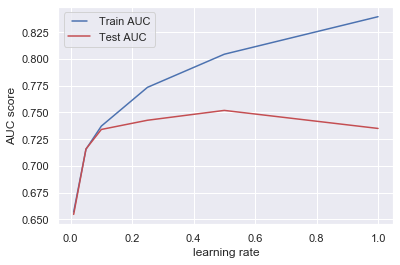

In [2496]:
choose_GB_learning_rate (X_train_p, X_test_p, y_train_p, y_test_p)

Using a high learning rate will result in overfitting.  For this data, 0.07 is optimal

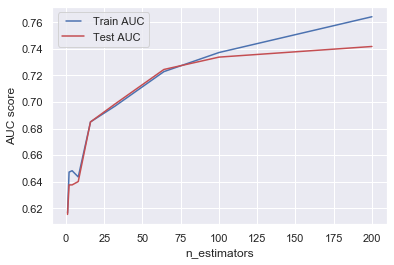

In [2497]:
choose_GB_n_estimators (X_train_p, X_test_p, y_train_p, y_test_p)

To avoid overfitting, using 100 trees

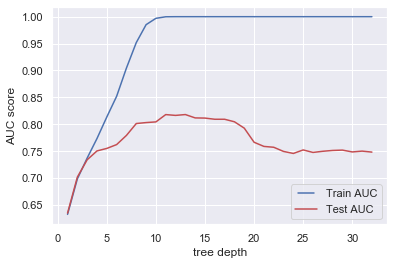

In [2498]:
choose_GB_max_depth (X_train_p, X_test_p, y_train_p, y_test_p)

The tree can grow to max depth of 8.  Overfit for large depth values.

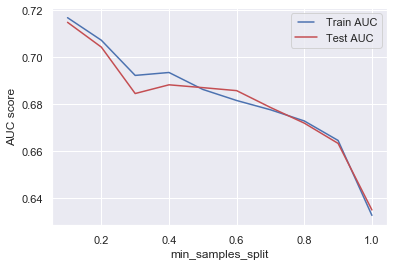

In [2499]:
choose_GB_min_samples_split (X_train_p, X_test_p, y_train_p, y_test_p)

We can split samples half.  Overall, even with all of the samples at each node, the model cannot learn enough about the dta.  This is an underfitting case. Will use the default value

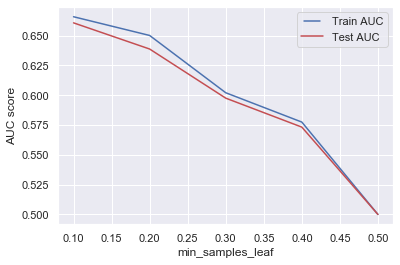

In [2500]:
choose_GB_min_samples_leaf (X_train_p, X_test_p, y_train_p, y_test_p)

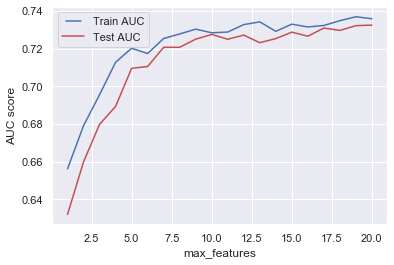

In [2501]:
choose_GB_max_features (X_train_p, X_test_p, y_train_p, y_test_p)

Try to use max_features = 20 seems to get us the optimal performance.

### Use learning_rate = 0.07, n_estimators=100, max_depth=8, max_features=20

Training cross validation scores:
roc_uac: 0.8785702272845342
accuracy: 0.7870863020179387
f1: 0.7714068589491189
precision: 0.8328097909697872
recall: 0.7186121171955674


Testing cross validation scores:
roc_uac: 0.8008401770680568
accuracy: 0.7243619845882696
f1: 0.7079629173526081
precision: 0.7523037631845806
recall: 0.6691418946637634


classification report:
              precision    recall  f1-score   support

         0.0       0.76      0.87      0.81      2014
         1.0       0.84      0.72      0.78      2013

    accuracy                           0.79      4027
   macro avg       0.80      0.79      0.79      4027
weighted avg       0.80      0.79      0.79      4027

confusion matrix:
[[1747  267]
 [ 559 1454]]
mean squared error:
0.205115470573628
r2 scores:
0.17953806711193498
ROC AUC Score: 
0.8833510681069572



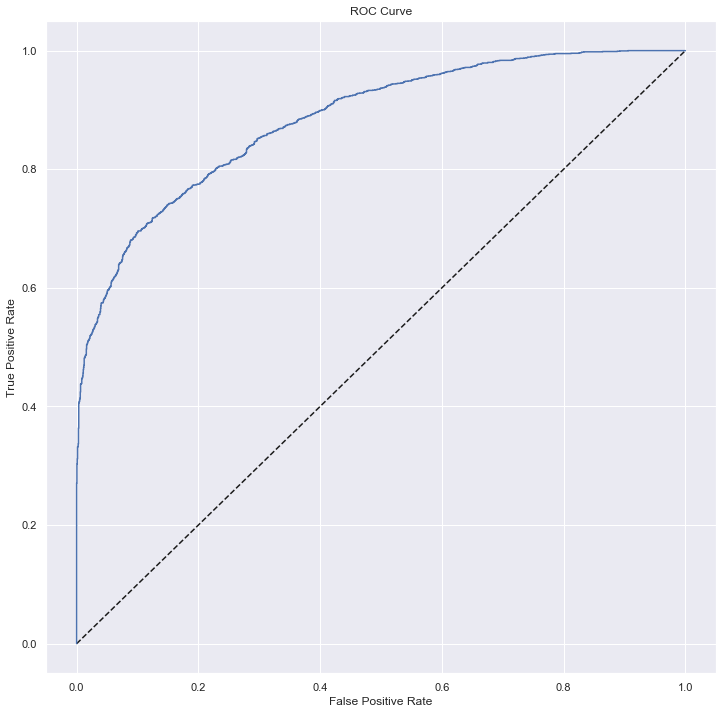

In [2532]:
m = GradientBoostingClassifier(learning_rate=0.07, n_estimators=100,max_depth=8,max_features=20)

print('Training cross validation scores:')
get_cross_val_scores(m, X_train, y_train, n_CV=10);
print('Testing cross validation scores:')
get_cross_val_scores(m, X_test, y_test, n_CV=4);
run_train_testing_split(m, X_train, X_test, y_train, y_test)

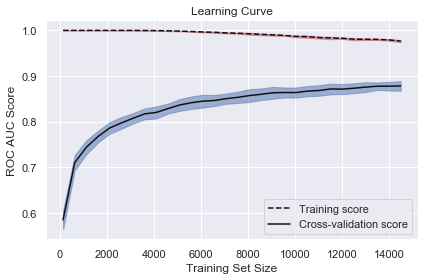

In [2533]:
plot_learning_curve(m, X_train, y_train)

•	Training score (red line) is at its maximum regardless of training examples

     o This shows severe overfitting
     
•	Cross-validation score (blue line) increases over time and reach 90%

•	The gap between cross-validation score and training score indicates high variance scenario

     o Reduce complexity of the model or gather more data


### Data Set 3. From the above learing curve, we can see that overfitting of learning.  Remove 7 features to reduce complexity and set max_features=10

In [2527]:
model_columns_r=[#'sv1stIn','sv1stWon','svpt','sv2ndWon','ace','df', 'SvGms',
               'sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct','bpSaved_pct',
               'bpFaced','bpSaved', 
               'player_age', 'player_rank', 'player_rank_points','player_ht',
               'svpt_std_var']
names_r= df[model_columns_r].columns

Xr=df[model_columns_r]
yr=df['player_hand_flag']

Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=p_test_size,  random_state= p_random_state, stratify=y)

# split training set into training and validation set for hyperparameter tuning
Xr_train_p, Xr_test_p, yr_train_p, yr_test_p = train_test_split(Xr_train, yr_train, test_size = p_test_size , random_state=p_random_state)


Training cross validation scores:
roc_uac: 0.9112506277308743
accuracy: 0.8263918582551396
f1: 0.8183831841226782
precision: 0.8580739586226998
recall: 0.7824430128076691


Testing cross validation scores:
roc_uac: 0.7955260793043779
accuracy: 0.7198932597452907
f1: 0.7065737406290054
precision: 0.7419819308552436
recall: 0.6746081053362366


classification report:
              precision    recall  f1-score   support

         0.0       0.80      0.89      0.85      2014
         1.0       0.88      0.78      0.83      2013

    accuracy                           0.84      4027
   macro avg       0.84      0.84      0.84      4027
weighted avg       0.84      0.84      0.84      4027

confusion matrix:
[[1801  213]
 [ 441 1572]]
mean squared error:
0.16240377452197666
r2 scores:
0.3503848618537596
ROC AUC Score: 
0.9170577443242558



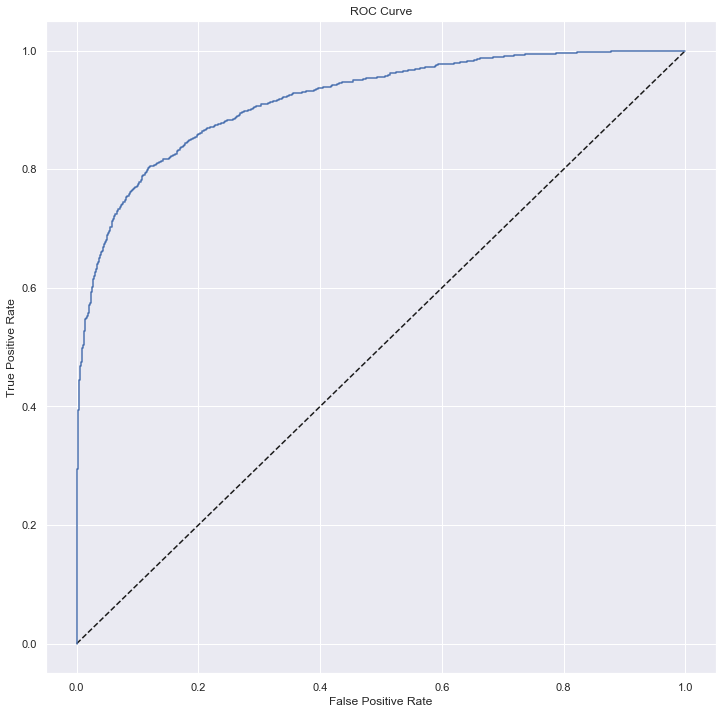

In [2528]:
mr = GradientBoostingClassifier(learning_rate=0.07, n_estimators=20,max_depth=15,max_features=10)

print('Training cross validation scores:')
get_cross_val_scores(mr, Xr_train, yr_train, n_CV=10);
print('Testing cross validation scores:')
get_cross_val_scores(mr, Xr_test, yr_test, n_CV=4);
run_train_testing_split(mr, Xr_train, Xr_test, yr_train, yr_test)

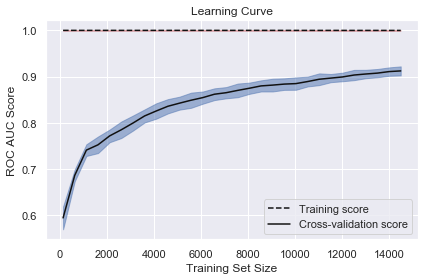

In [2529]:
plot_learning_curve(mr, Xr_train, yr_train)

• The training and test scores have not yet converged, so potentially this model would benefit from more training data.

• Cross-validation score (blue line) increases over time

• Huge gap between cross-validation score and training score indicates high variance scenario

    o Reduce complexity of the model or gather more data

#### Data Set 1 

In [2513]:
model_columns=['sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct','bpFaced','bpSaved', 
               'player_age', 'player_rank', 'svpt_std_var', 'bpSaved_pct']
names= df[model_columns].columns

X=df[model_columns]
y=df['player_hand_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=p_test_size,  random_state= p_random_state, stratify=y)

# split training set into training and validation set for hyperparameter tuning
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_train, y_train, test_size = p_test_size , random_state=p_random_state)


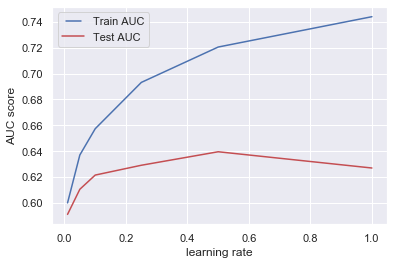

In [2514]:
choose_GB_learning_rate (X_train_p, X_test_p, y_train_p, y_test_p)

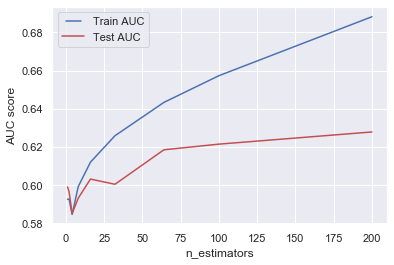

In [2515]:
choose_GB_n_estimators (X_train_p, X_test_p, y_train_p, y_test_p)

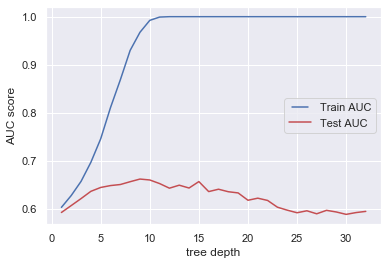

In [2516]:
choose_GB_max_depth (X_train_p, X_test_p, y_train_p, y_test_p)

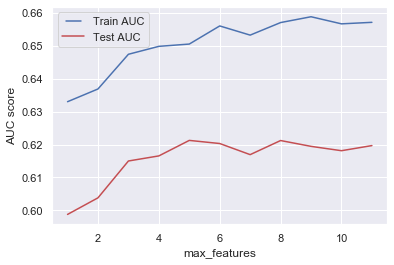

In [2519]:
choose_GB_max_features (X_train_p, X_test_p, y_train_p, y_test_p)

Training cross validation scores:
roc_uac: 0.6828147517397218
accuracy: 0.6203662895078113
f1: 0.5745874785168942
precision: 0.6535581624404802
recall: 0.5129730437865081


Testing cross validation scores:
roc_uac: 0.6329876684250875
accuracy: 0.5882809327340132
f1: 0.5477719181852336
precision: 0.6076163879085643
recall: 0.49923869481523553


classification report:
              precision    recall  f1-score   support

         0.0       0.58      0.73      0.64      2014
         1.0       0.63      0.47      0.54      2013

    accuracy                           0.60      4027
   macro avg       0.61      0.60      0.59      4027
weighted avg       0.61      0.60      0.59      4027

confusion matrix:
[[1465  549]
 [1067  946]]
mean squared error:
0.4012912838341197
r2 scores:
-0.605165234318539
ROC AUC Score: 
0.6584014975154051



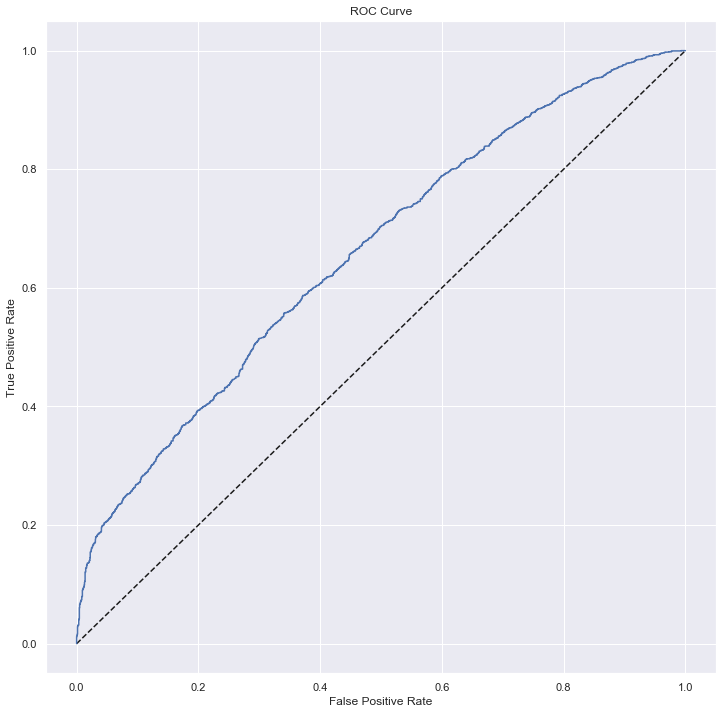

In [2520]:
#set1
#gb1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=30,max_depth=5,max_features=8)
gb1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=20,max_depth=5,max_features=5)

print('Training cross validation scores:')
get_cross_val_scores(gb1, X_train, y_train, n_CV=10);
print('Testing cross validation scores:')
get_cross_val_scores(gb1, X_test, y_test, n_CV=4);
run_train_testing_split(gb1, X_train, X_test, y_train, y_test)

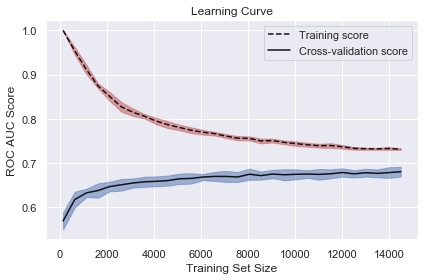

In [2526]:
plot_learning_curve(gb1, X_train, y_train)

### Compared the performance between KNeighborClassifier, LogisticRegression and RandomForestClassifier, and Gradient Boosting.  Gradient Boosting model performed best. 

### An ensemble is just a collection of predictors which come together (e.g. mean of all predictions) to give a final prediction. The reason we use ensembles is that many different predictors trying to predict same target variable will perform a better job than any single predictor alone.

### It takes more than one features to predict player hand.  As a bagging ensemble, Random Forest model performs better than classifier (KNN) and regressor (Logistic).  To further reduce variance and bias, boosting ensemble Gradient Boosting (GBM) algorithm performs better than Random Forest. 

### Gradient Boosting model has the ROC AUC score at 91%.   Gradient Boosting learning curve shows the potential to be further tuned.